# Linear Regression
Now, we have chosen transformations for the features and created subsamples for our variables of interest. Next, we want to see if they still give predictive power and how much using a linear regression model.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sma
import statsmodels as sms
from statsmodels.stats import outliers_influence

import warnings
warnings.filterwarnings(action="ignore")

/home/phil/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
data_path = "/media/veracrypt1/SPON_dataset_tables/"
plot_path = "plots/"

In [3]:
def prepare_type(df_data):
    # Nominal features
    df_data["sex"] = df_data["sex"].astype("category")
    df_data["familyStatus"] = df_data["familyStatus"].astype("category")
    df_data["employment"] = df_data["employment"].astype("category")
    df_data["housing"] = df_data["housing"].astype("category")
    df_data["east_west"] = df_data["east_west"].astype("category")

    # Ordinal features
    cat_ordtype = pd.api.types.CategoricalDtype(categories=[500, 1000, 2000, 3000, 4000, 5000], ordered=True)

    df_data["monthlyIncome"] = df_data["monthlyIncome"].astype(cat_ordtype)
    df_data["activeLoanAmount"] = df_data["activeLoanAmount"].astype(cat_ordtype)
    df_data["paidOffLoanAmount"] = df_data["paidOffLoanAmount"].astype(cat_ordtype)
    
    return df_data

In [4]:
def do_scatter(fitted, res, y_lab, fit_lowess=False):
    if fit_lowess:
        seaborn.regplot(fitted, res, lowess=True)
    else:
        plt.scatter(fitted, res)
    plt.xlabel(y_lab)
    plt.ylabel("residuals")
    plt.show()
    plt.close()
    

def do_hist(res):
    plt.hist(res)
    plt.xlabel("residuals")
    plt.ylabel("frequency")
    plt.show()
    plt.close()

In [5]:
def get_feature_lists(domain):
    # Separate Columns into data types as well as predictors and target

    nominal = ["sex", "east_west", "mailOrder"]
    nom_idx = len(nominal)

    metric = ['monthlyIncome', 'age', 'relocation', # questionnaire data
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan', # feature counts
              domain+'_req', 'finance_year', # request/time counts
              'credit_days', 'credit_card_days', 'giro_days'] # time-based

    target = ["score"]



    # Separate Columns into counts (discrete with zero-inflation) and non-counts

    counts = ['relocation', 
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan',
              domain+'_req', 'finance_year']

    non_counts = ["female", "east", "mailOrder",
                  'monthlyIncome', 'age', 
                  'credit_days', 'credit_card_days', 'giro_days']
    
    return nominal, nom_idx, metric, target, counts, non_counts

In [6]:
# dataset and list of Features that we selected in the ranking
def create_dataset(ds, relevant_feats, nominal, metric, target, feat_list, standardized=True):
    
    ds.iloc[:, -26:] = ds.iloc[:, -26:].fillna(0)

    Xy = ds[relevant_feats + ["weight"]]
    print(Xy.shape)
    Xy = Xy.dropna()
    print(Xy.shape)
    
    #metric.remove("monthlyIncome")
    #nominal += ["monthlyIncome"]
    
    df_metric = Xy[metric] # [:, (nom_idx+1):]
    df_nominal = Xy[nominal] # [:, 1:(nom_idx+1)]
    y = Xy[target] # [:, 0]
    
    ###############
    
    # Transform features
    # Nominal
    # Code nominal feature
    df_female = pd.get_dummies(df_nominal.sex.astype("category"))["female"].reset_index(drop=True).to_frame()
    df_east = pd.get_dummies(df_nominal.east_west.astype("category"))["east"].reset_index(drop=True).to_frame()
    df_mail = df_nominal.mailOrder.astype(int).reset_index(drop=True).to_frame()

    # Ordinal
    #df_monthlyIncome = df_nominal.monthlyIncome.reset_index(drop=True).cat.codes.to_frame()
    #df_monthlyIncome.columns = ["monthlyIncome"]
    df_metric.monthlyIncome = df_metric.monthlyIncome.cat.codes

    df_nominal = pd.concat([df_female, df_east, df_mail], axis=1)

    # Metric
    # Expand metric features
    poly_2 = df_metric.apply(lambda x: x**2)
    poly_2.columns = poly_2.columns + "_**2"

    poly_3 = df_metric.apply(lambda x: x**3)
    poly_3.columns = poly_3.columns + "_**3"

    log_2 = df_metric.apply(lambda x: np.log(x+1))
    log_2.columns = log_2.columns + "_log2"

    # Compute interaction terms
    interactions = pd.DataFrame(index = df_metric.index)

    for idx, feat in enumerate(df_metric.columns):
        for interact in df_metric.columns[idx+1:]:
            interactions[feat+"*"+interact] = df_metric[feat]*df_metric[interact]
            
    # append features
    metric_Xy = pd.concat([y, df_metric, poly_2, poly_3, log_2, interactions], axis=1)
    
    ################
    
    # scale metric features
    scaler = StandardScaler()
    metric_Xy_scaled = pd.DataFrame(scaler.fit_transform(metric_Xy), columns=metric_Xy.columns)

    # concatenate all features and separate y
    if standardized:
        y = metric_Xy_scaled["score"]
        X = pd.concat([df_nominal, 
                       metric_Xy_scaled, 
                       Xy["weight"].to_frame().reset_index(drop=True)], axis=1)
    else:
        y = y.reset_index(drop=True)
        X = pd.concat([df_nominal, 
                       metric_Xy.reset_index(drop=True), 
                       Xy["weight"].to_frame().reset_index(drop=True)], axis=1)

    X = X[feat_list+["weight"]]

    return X, y

In [7]:
def evaluate_vifs(X, thresh=10):
    
    # Add intercept term
    X = sma.add_constant(X)
    
    # compute vifs
    vifs = [outliers_influence.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for i, col in enumerate(X.columns):
        if vifs[i] >= thresh:
            print("%s has to high vif=%f"%(col, vifs[i]))

In [8]:
def do_regression(X, y):
    
    weights = X.weight.values
    
    X.drop("weight", axis=1, inplace=True)

    # Evaluate VIF except from column "weight"
    evaluate_vifs(X)
        
    # Prune features with just one characteristic
    no_info = []
    for i in X.columns:
        if len(X[i].unique()) == 1:
            print("Has only one characteristic: %s"%(i))
            no_info.append(i)
    
    X.drop(no_info, axis=1, inplace=True)

    # Add intercept term (and ignore weight-column)
    X = sma.add_constant(X)
    print(X.shape, y.shape)

    # Apply regression
    reg = sma.WLS(y, X, weights=weights).fit()

    # Check Assumptions
    # random, normal
    do_scatter(y, reg.resid, y_lab="y_scaled")
    do_scatter(reg.fittedvalues, reg.resid, y_lab="fitted_values", fit_lowess=True)
    print("Mean of residuals", np.mean(reg.resid))
    print("RMSE: %f"%(np.sqrt(((reg.resid)**2).mean())))
    do_hist(reg.resid)
    print("----")
    # Homoscedasticity
    print("Het-Breuschpagan for homogenity:\n", sms.stats.diagnostic.het_breuschpagan(reg.resid, X))
    print("Het white for homogenity:\n", sms.stats.diagnostic.het_white(reg.resid, X))

    return reg

In [9]:
def persist_model_quality(linreg, filename):
    model_quality = {"rsq": [linreg.rsquared],
                     "rsq_adj": [linreg.rsquared_adj],
                     "aic": [linreg.aic],
                     "ll": [linreg.llf],
                     "f_stat": [linreg.fvalue],
                     "f_p": [linreg.f_pvalue],
                     "rmse": [np.sqrt(((linreg.resid)**2).mean())]}

    pd.DataFrame.from_dict(model_quality).to_csv(filename, index=False, sep=";")

In [10]:
def persist_model_coeffs(linreg, predictors, filename):
    ci = linreg.conf_int()
    model_coeffs = {"predictor": predictors,
                    "coefficient": linreg.params.values,
                    "pvalue": linreg.pvalues.values,
                    "standard error": linreg.bse.values,
                    "0.025": ci.values[:, 0],
                    "0.975": ci.values[:, 1]}
    
    pd.DataFrame.from_dict(model_coeffs).to_csv(filename, index=False, sep=";")

In [11]:
# functions for regression
def convert_to_unstandardized(sd_y, sd_x, beta):
    return beta * (sd_y/sd_x)

def get_semi_partial_corr(y, a, X):
    reg = sma.OLS(a, sma.add_constant(X))
    residuals = reg.fit().resid
    return stats.pearsonr(residuals, y)[0]

def multicol_index(spc, a, X):
    reg = sma.OLS(a, sma.add_constant(X))
    a_hat = reg.fit().fittedvalues
    r2_a, _, _ = compute_r2(a_hat.values, a.values)
    return 1 / np.sqrt(1-r2_a)

## Age

In [12]:
table2 = pd.read_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_age.csv", sep=";")

In [13]:
table2 = prepare_type(table2)

### Versandhandel - Version 1

In [14]:
domain = "Versandhandel"

In [15]:
variable = "age_log2"

#### Transformations & Standardization

In [16]:
# As an example we use Versandhandel V1
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

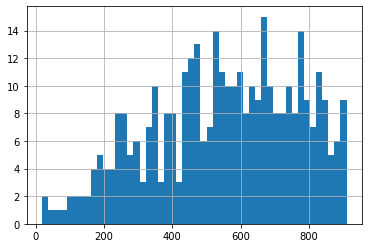

In [17]:
df_data["score"].hist(bins=50)
plt.show()
plt.close()

"""df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(1000-x)*100)
df_data["score"].hist(bins=50)
plt.show()
plt.close()""";

In [18]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [19]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [20]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [21]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(360, 25)
(360, 25)


(360, 2) (360,)


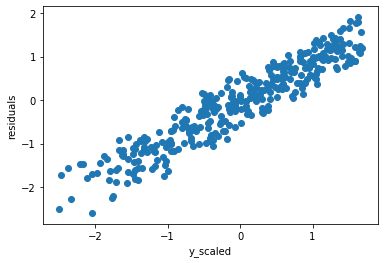

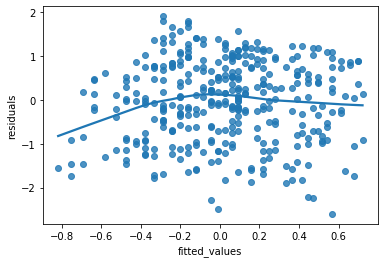

Mean of residuals -0.023315027236311566
RMSE: 0.933045


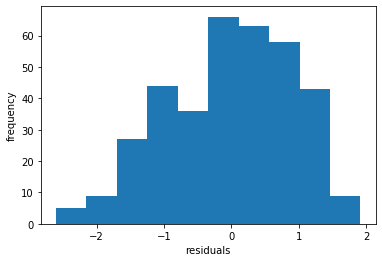

----
Het-Breuschpagan for homogenity:
 (0.006003577389623871, 0.9382395091989084, 0.005970323746644934, 0.9384536154474132)
Het white for homogenity:
 (0.392689558541397, 0.82172887075122, 0.19492119365868518, 0.8229870244892972)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.110
Model:                            WLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     44.15
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.13e-10
Time:                        14:10:05   Log-Likelihood:                -494.56
No. Observations:                 360   AIC:                             993.1
Df Residuals:                     358   BIC:                             1001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0233      0.050      0.468      0.640      -0.075       0.121
age_log2       0.3318      0.050      6.645      0.000       0.234       0.430
==============================================================================
Omnibus:                        9.776   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.497
Skew:                          -0.356   Prob(JB):                      0.00867
Kurtosis:                       2.647   Cond. No.                         1.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [23]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

Unit influence of variable: 282.445047



In [24]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [25]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(360, 21) (360,)


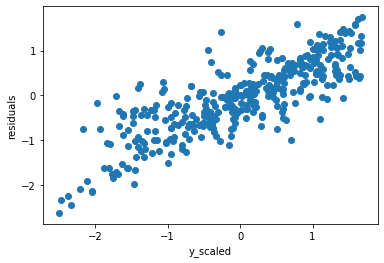

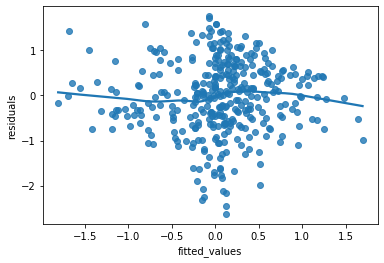

Mean of residuals -0.04762088332146258
RMSE: 0.811947


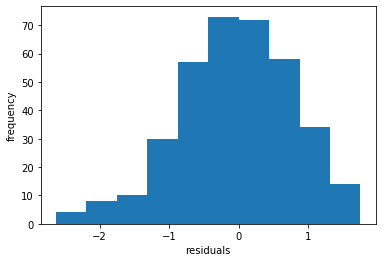

----
Het-Breuschpagan for homogenity:
 (29.992445911020667, 0.0699761565112613, 1.5404858218934259, 0.06571512757190695)
Het white for homogenity:
 (109.10718297299555, 0.9999999995458235, 0.3015411514954348, 0.9999999999999991)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.338
Model:                            WLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     8.657
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.12e-20
Time:                        14:10:25   Log-Likelihood:                -441.22
No. Observations:                 360   AIC:                             924.4
Df Residuals:                     339   BIC:                             1006.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1203      0.138      0.869      0.385      -0.152       0.392
solvency_log2         -0.3694      0.058     -6.420      0.000      -0.483      -0.256
credit_card_days       0.2087      0.066      3.153      0.002       0.078       0.339
female                 0.3632      0.154      2.361      0.019       0.061       0.666
finance_year_log2     -0.1607      0.071     -2.252      0.025      -0.301      -0.020
relocation_**2        -0.0420      0.047     -0.886      0.376      -0.135       0.051
mailOrder             -0.1516      0.141     -1.077      0.282      -0.428       0.125
credit_days_**2       -0.0690      0.055     -1.256      0.210      -0.177       0.039
secured_loan_log2      0.0898      0.052      1.733      0.084      -0.012       0.192
conditions_log2       -0.0633      0.059     -1.066      0.287      -0.180       0.053
identity_log2         -0.0043      0.048     -0.089      0.929      -0.099       0.091
east                   0.1208      0.110      1.101      0.272      -0.095       0.337
business_relation     -0.0207      0.048     -0.432      0.666      -0.115       0.074
credit_card            0.1131      0.072      1.581      0.115      -0.028       0.254
banking_connection    -0.0471      0.045     -1.043      0.298      -0.136       0.042
telecom_log2           0.0338      0.051      0.663      0.508      -0.067       0.134
giro_days              0.1104      0.066      1.679      0.094      -0.019       0.240
monthlyIncome          0.1077      0.048      2.248      0.025       0.013       0.202
giro                  -0.0186      0.084     -0.223      0.824      -0.183       0.146
global_credit_log2     0.0156      0.048      0.327      0.744      -0.078       0.109
unsecured_loan_**3     0.0189      0.049      0.387      0.699      -0.077       0.115
==============================================================================
Omnibus:                        9.222   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.349
Skew:                          -0.342   Prob(JB):                      0.00933
Kurtosis:                       3.393   Cond. No.                         9.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [27]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [28]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(360, 22) (360,)


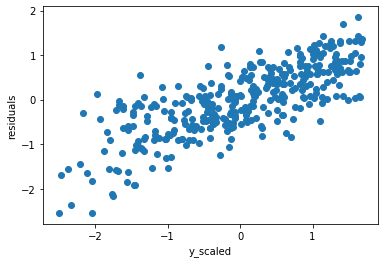

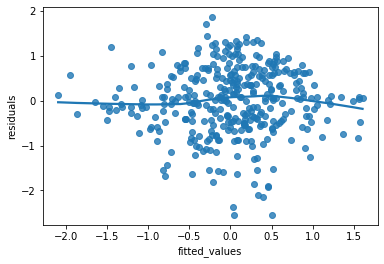

Mean of residuals -0.01550652572090117
RMSE: 0.762021


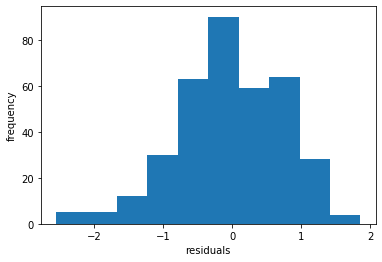

----
Het-Breuschpagan for homogenity:
 (21.024669829981843, 0.4574384694836006, 0.998294084167124, 0.46473550991686274)
Het white for homogenity:
 (125.64048192817856, 0.9999999956992334, 0.30802321249035036, 0.9999999999999967)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.410
Model:                            WLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     11.20
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           6.92e-28
Time:                        14:10:31   Log-Likelihood:                -420.44
No. Observations:                 360   AIC:                             884.9
Df Residuals:                     338   BIC:                             970.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0662      0.131      0.505      0.614      -0.192       0.324
age_log2               0.2766      0.043      6.431      0.000       0.192       0.361
solvency_log2         -0.3585      0.054     -6.587      0.000      -0.466      -0.251
credit_card_days       0.2092      0.063      3.344      0.001       0.086       0.332
female                 0.3469      0.145      2.385      0.018       0.061       0.633
finance_year_log2     -0.1602      0.067     -2.374      0.018      -0.293      -0.027
relocation_**2        -0.0354      0.045     -0.790      0.430      -0.123       0.053
mailOrder             -0.1221      0.133     -0.917      0.360      -0.384       0.140
credit_days_**2       -0.0903      0.052     -1.734      0.084      -0.193       0.012
secured_loan_log2      0.0824      0.049      1.683      0.093      -0.014       0.179
conditions_log2       -0.0585      0.056     -1.042      0.298      -0.169       0.052
identity_log2         -0.0049      0.046     -0.107      0.915      -0.095       0.085
east                   0.1100      0.104      1.060      0.290      -0.094       0.314
business_relation     -0.0188      0.045     -0.415      0.678      -0.108       0.070
credit_card            0.1054      0.068      1.558      0.120      -0.028       0.238
banking_connection    -0.0480      0.043     -1.125      0.261      -0.132       0.036
telecom_log2           0.0361      0.048      0.749      0.454      -0.059       0.131
giro_days              0.0585      0.063      0.933      0.351      -0.065       0.182
monthlyIncome          0.0815      0.045      1.792      0.074      -0.008       0.171
giro                   0.0304      0.079      0.383      0.702      -0.126       0.186
global_credit_log2     0.0140      0.045      0.311      0.756      -0.075       0.103
unsecured_loan_**3     0.0055      0.046      0.118      0.906      -0.085       0.096
==============================================================================
Omnibus:                       22.076   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.288
Skew:                          -0.537   Prob(JB):                     1.96e-06
Kurtosis:                       3.775   Cond. No.                         9.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [30]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

spc = get_semi_partial_corr(y_scaled, X_scaled[variable], X_scaled.drop([variable, "weight"], axis=1))
print("Semi-Partial Coefficient: %f\nDifference to regression coefficient: %f"%(spc, spc - linreg.params[1]))

Unit influence of variable: 235.417289

Semi-Partial Coefficient: 0.274533
Difference to regression coefficient: -0.002031


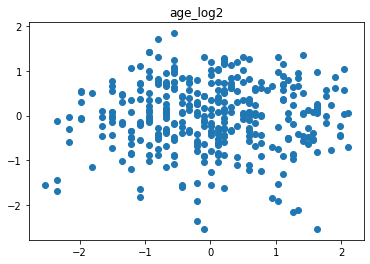

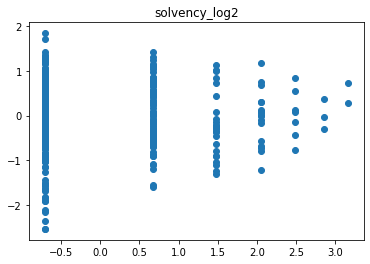

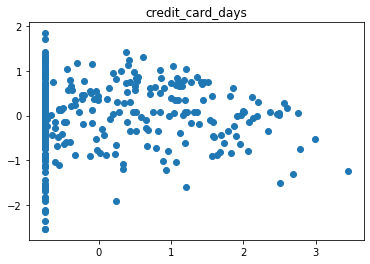

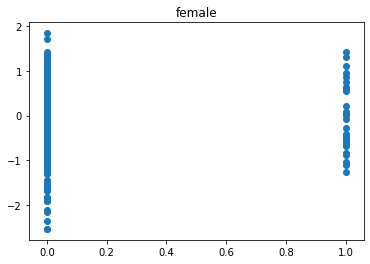

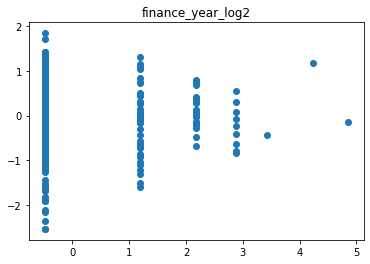

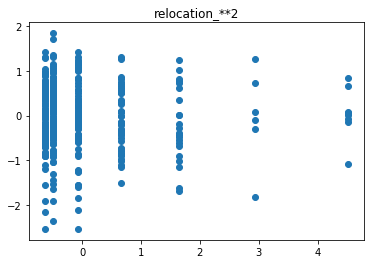

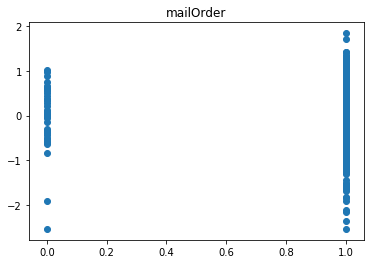

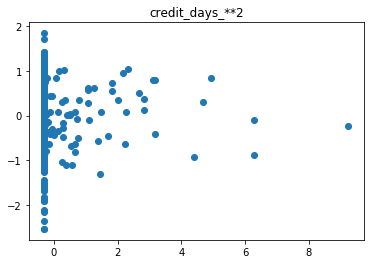

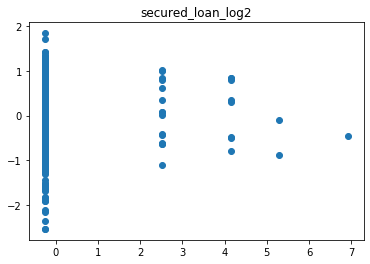

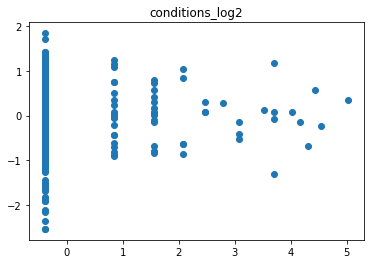

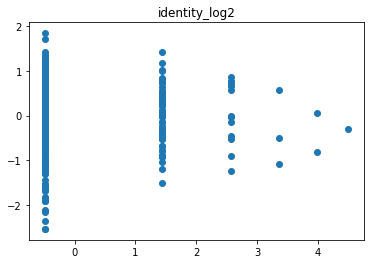

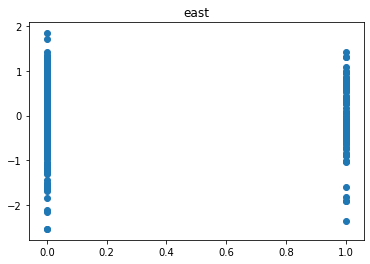

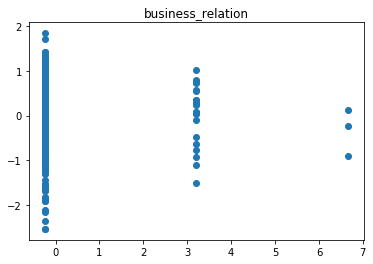

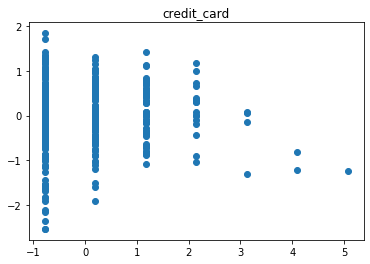

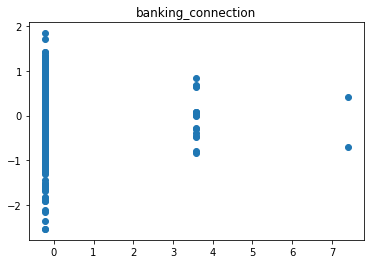

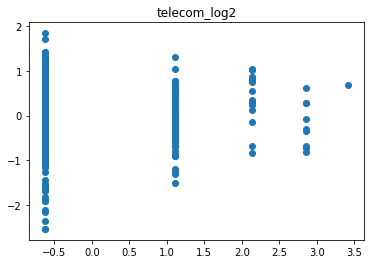

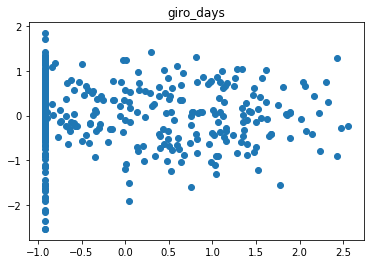

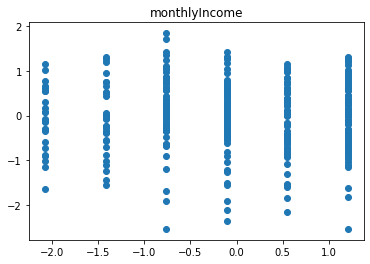

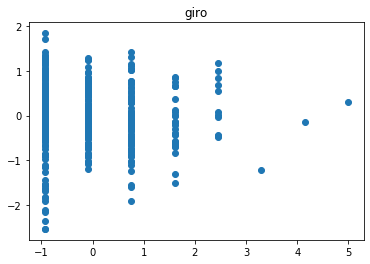

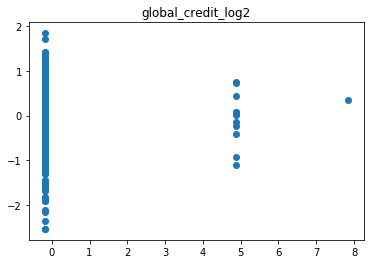

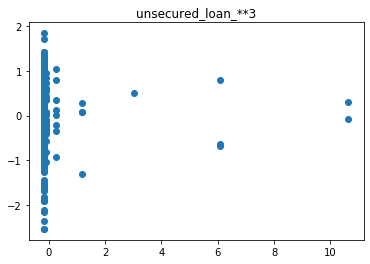

In [31]:
# EXAMINE RESIDUALS vs EACH VARIABLE
for f in feat_l:
    plt.scatter(X_scaled[f], linreg.resid)
    plt.title(f)
    plt.show()
    plt.close()

In [32]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Versandhandel, Version 2

In [33]:
variable = "age"

In [34]:
# As an example we use Versandhandel V1
version = 2

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

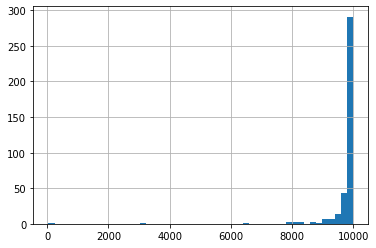

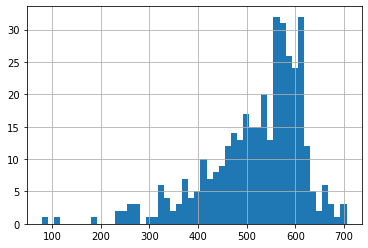

In [35]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)
df_data["score"].hist(bins=50)
plt.show()

In [36]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [37]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [38]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [39]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(376, 25)
(376, 25)


(376, 2) (376,)


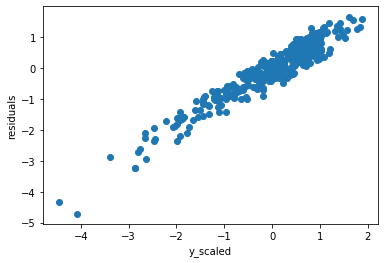

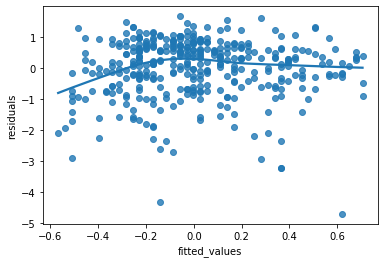

Mean of residuals -0.008113183066658404
RMSE: 0.950824


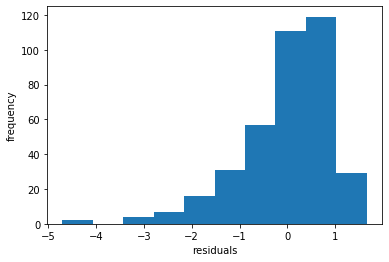

----
Het-Breuschpagan for homogenity:
 (0.0010763514673337582, 0.9738278613860919, 0.0010706292583975408, 0.9739149534800465)
Het white for homogenity:
 (2.933226783697667, 0.23070547271960606, 1.4663508906016685, 0.23209317802813997)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.083
Model:                            WLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     33.64
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.42e-08
Time:                        14:11:11   Log-Likelihood:                -520.77
No. Observations:                 376   AIC:                             1046.
Df Residuals:                     374   BIC:                             1053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.049      0.165      0.869      -0.089       0.105
age            0.2833      0.049      5.800      0.000       0.187       0.379
==============================================================================
Omnibus:                      103.524   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.647
Skew:                          -1.339   Prob(JB):                     6.85e-57
Kurtosis:                       6.055   Cond. No.                         1.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [41]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.std(), linreg.params[1]))

Unit influence of variable: 2.788995



In [42]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [43]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(376, 21) (376,)


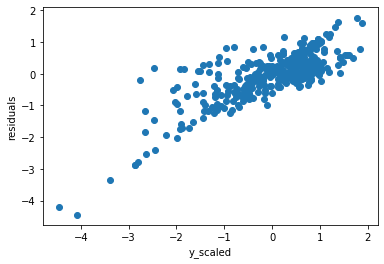

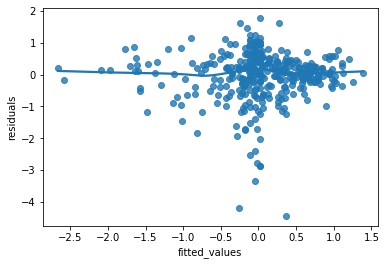

Mean of residuals -0.023752266633813177
RMSE: 0.772619


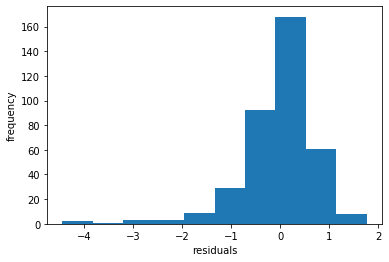

----
Het-Breuschpagan for homogenity:
 (29.348089256904363, 0.08112817380870446, 1.5027425730709834, 0.0770758329933683)
Het white for homogenity:
 (81.45751306274067, 1.0, 0.19059945464857975, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.400
Model:                            WLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     11.81
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           8.25e-29
Time:                        14:11:26   Log-Likelihood:                -441.06
No. Observations:                 376   AIC:                             924.1
Df Residuals:                     355   BIC:                             1007.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0275      0.119     -0.230      0.818      -0.262       0.207
credit_card_days_log2      0.3843      0.065      5.949      0.000       0.257       0.511
credit_card_**2           -0.0855      0.055     -1.546      0.123      -0.194       0.023
female                     0.3388      0.130      2.616      0.009       0.084       0.594
giro                      -0.3181      0.076     -4.206      0.000      -0.467      -0.169
relocation                -0.1002      0.044     -2.279      0.023      -0.187      -0.014
solvency                  -0.2729      0.051     -5.375      0.000      -0.373      -0.173
giro_days_log2             0.2152      0.075      2.865      0.004       0.067       0.363
telecom_**2               -0.1183      0.044     -2.691      0.007      -0.205      -0.032
secured_loan_log2          0.1230      0.051      2.432      0.016       0.024       0.222
unsecured_loan_log2       -0.0816      0.055     -1.475      0.141      -0.190       0.027
finance_year_**2           0.0126      0.052      0.244      0.807      -0.089       0.114
conditions_log2           -0.1732      0.055     -3.146      0.002      -0.281      -0.065
credit_days_**3           -0.0029      0.047     -0.062      0.951      -0.095       0.089
banking_connection_**3     0.0198      0.047      0.423      0.673      -0.072       0.112
east                       0.0320      0.103      0.310      0.756      -0.171       0.235
identity_**3              -0.0976      0.044     -2.199      0.029      -0.185      -0.010
business_relation         -0.0511      0.044     -1.172      0.242      -0.137       0.035
monthlyIncome             -0.0026      0.046     -0.056      0.955      -0.094       0.088
global_credit             -0.0045      0.041     -0.109      0.913      -0.086       0.077
mailOrder                  0.0038      0.121      0.031      0.975      -0.235       0.243
==============================================================================
Omnibus:                      166.065   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              978.394
Skew:                          -1.786   Prob(JB):                    3.50e-213
Kurtosis:                      10.050   Cond. No.                         8.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [45]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [46]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(376, 22) (376,)


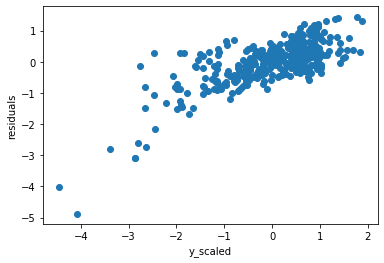

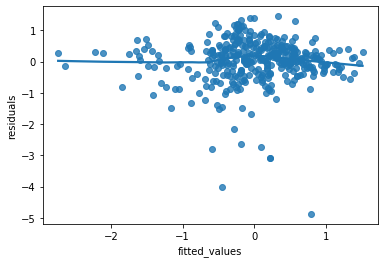

Mean of residuals 0.002467635832180188
RMSE: 0.725851


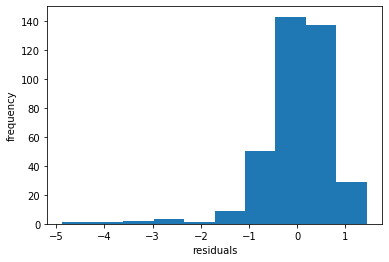

----
Het-Breuschpagan for homogenity:
 (24.938211438908063, 0.24985011861461254, 1.1974729421574501, 0.2498283023702128)
Het white for homogenity:
 (107.53656734305376, 0.9999999999999946, 0.22531679093801774, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.467
Model:                            WLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     14.74
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           9.93e-37
Time:                        14:11:30   Log-Likelihood:                -418.82
No. Observations:                 376   AIC:                             881.6
Df Residuals:                     354   BIC:                             968.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1100      0.113     -0.971      0.332      -0.333       0.113
age                        0.2691      0.040      6.668      0.000       0.190       0.348
credit_card_days_log2      0.3779      0.061      6.198      0.000       0.258       0.498
credit_card_**2           -0.0898      0.052     -1.720      0.086      -0.192       0.013
female                     0.2972      0.122      2.428      0.016       0.056       0.538
giro                      -0.3324      0.071     -4.654      0.000      -0.473      -0.192
relocation                -0.0444      0.042     -1.049      0.295      -0.128       0.039
solvency                  -0.2508      0.048     -5.221      0.000      -0.345      -0.156
giro_days_log2             0.2654      0.071      3.722      0.000       0.125       0.406
telecom_**2               -0.1246      0.041     -3.002      0.003      -0.206      -0.043
secured_loan_log2          0.1165      0.048      2.441      0.015       0.023       0.210
unsecured_loan_log2       -0.0914      0.052     -1.749      0.081      -0.194       0.011
finance_year_**2           0.0156      0.049      0.319      0.750      -0.080       0.112
conditions_log2           -0.1581      0.052     -3.039      0.003      -0.260      -0.056
credit_days_**3           -0.0025      0.044     -0.056      0.955      -0.089       0.084
banking_connection_**3     0.0313      0.044      0.708      0.479      -0.056       0.118
east                       0.0393      0.097      0.403      0.687      -0.152       0.231
identity_**3              -0.1197      0.042     -2.848      0.005      -0.202      -0.037
business_relation         -0.0351      0.041     -0.850      0.396      -0.116       0.046
monthlyIncome             -0.0251      0.044     -0.573      0.567      -0.111       0.061
global_credit             -0.0076      0.039     -0.194      0.846      -0.085       0.069
mailOrder                  0.0725      0.115      0.630      0.529      -0.154       0.299
==============================================================================
Omnibus:                      216.417   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2153.534
Skew:                          -2.254   Prob(JB):                         0.00
Kurtosis:                      13.823   Cond. No.                         8.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [48]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.std(), linreg.params[1]))

spc = get_semi_partial_corr(y_scaled, X_scaled[variable], X_scaled.drop([variable, "weight"], axis=1))
print("Semi-Partial Coefficient: %f\nDifference to regression coefficient: %f"%(spc, spc - linreg.params[1]))

Unit influence of variable: 2.648532

Semi-Partial Coefficient: 0.262365
Difference to regression coefficient: -0.006708


In [49]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Versandhandel, Version 3

In [50]:
variable = "age_log2"

In [51]:
version = 3

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

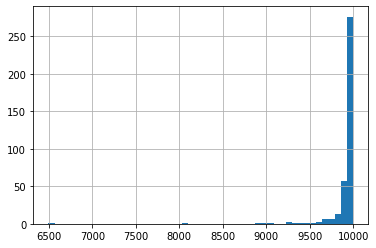

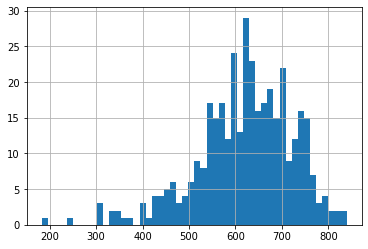

In [52]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)

df_data["score"].hist(bins=50)
plt.show()

In [53]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [54]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [55]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [56]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(375, 25)
(375, 25)


(375, 2) (375,)


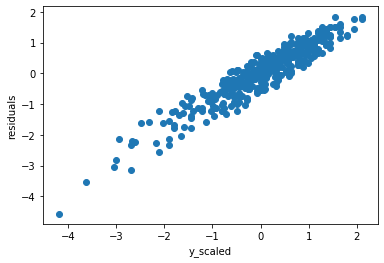

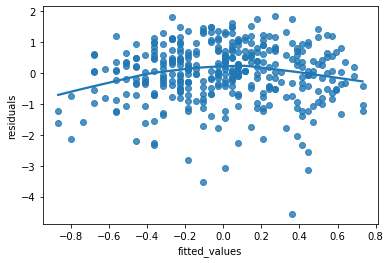

Mean of residuals -0.0030558087519644795
RMSE: 0.932616


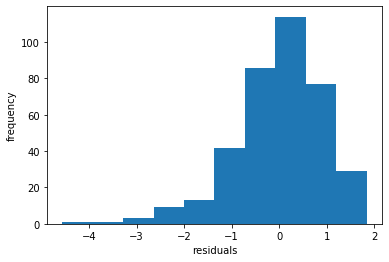

----
Het-Breuschpagan for homogenity:
 (0.44968862645791696, 0.5024828577793476, 0.44782730804227355, 0.5037825262705997)
Het white for homogenity:
 (0.5605217697622344, 0.7555865946216178, 0.2784349814515699, 0.7571250967695073)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.111
Model:                            WLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     46.44
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           3.80e-11
Time:                        14:11:59   Log-Likelihood:                -522.06
No. Observations:                 375   AIC:                             1048.
Df Residuals:                     373   BIC:                             1056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.050      0.061      0.951      -0.095       0.101
age_log2       0.3395      0.050      6.815      0.000       0.242       0.437
==============================================================================
Omnibus:                       78.615   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.783
Skew:                          -1.040   Prob(JB):                     4.55e-41
Kurtosis:                       5.750   Cond. No.                         1.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [58]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

Unit influence of variable: 142.989892



In [59]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [60]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(375, 21) (375,)


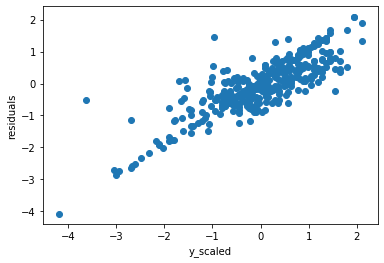

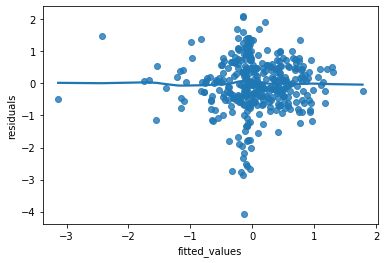

Mean of residuals -0.04609733446843395
RMSE: 0.830858


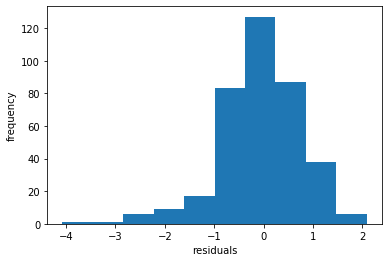

----
Het-Breuschpagan for homogenity:
 (32.6873276239294, 0.036502947740368975, 1.6901673400741881, 0.03293332039444141)
Het white for homogenity:
 (121.91860513922794, 0.9999999895329429, 0.3372157153014326, 0.9999999999999157)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.314
Model:                            WLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     8.115
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.99e-19
Time:                        14:12:13   Log-Likelihood:                -473.31
No. Observations:                 375   AIC:                             988.6
Df Residuals:                     354   BIC:                             1071.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0550      0.127     -0.434      0.664      -0.304       0.194
credit_card_days_log2      0.4058      0.078      5.170      0.000       0.251       0.560
credit_card               -0.2102      0.079     -2.645      0.009      -0.367      -0.054
solvency                  -0.1691      0.051     -3.307      0.001      -0.270      -0.069
secured_loan_log2          0.1846      0.049      3.735      0.000       0.087       0.282
telecom                   -0.1873      0.050     -3.754      0.000      -0.285      -0.089
giro_days                  0.2136      0.057      3.778      0.000       0.102       0.325
relocation                -0.0362      0.048     -0.758      0.449      -0.130       0.058
finance_year_log2         -0.1722      0.067     -2.572      0.011      -0.304      -0.041
global_credit_log2        -0.0666      0.047     -1.406      0.161      -0.160       0.027
giro_**2                  -0.0211      0.062     -0.338      0.736      -0.144       0.102
unsecured_loan            -0.0356      0.052     -0.679      0.498      -0.139       0.068
business_relation_log2    -0.0384      0.048     -0.805      0.421      -0.132       0.055
identity_**2              -0.0399      0.048     -0.828      0.408      -0.135       0.055
credit_days_**3           -0.0379      0.051     -0.741      0.459      -0.139       0.063
monthlyIncome              0.0661      0.049      1.347      0.179      -0.030       0.162
conditions_log2           -0.0185      0.060     -0.307      0.759      -0.137       0.100
banking_connection        -0.0142      0.051     -0.277      0.782      -0.115       0.087
east                      -0.0046      0.124     -0.037      0.970      -0.247       0.238
female                     0.0699      0.160      0.437      0.662      -0.245       0.384
mailOrder                  0.1102      0.131      0.841      0.401      -0.147       0.368
==============================================================================
Omnibus:                       54.886   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.852
Skew:                          -0.695   Prob(JB):                     1.29e-32
Kurtosis:                       5.732   Cond. No.                         8.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [62]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [63]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(375, 22) (375,)


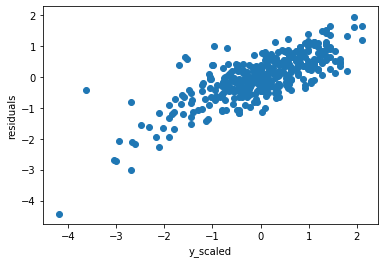

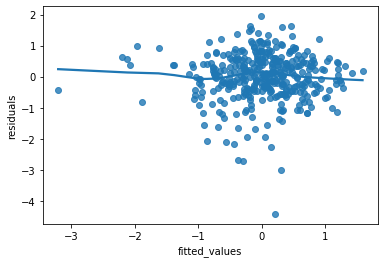

Mean of residuals -0.006532556107453323
RMSE: 0.771858


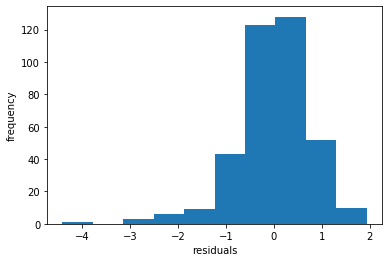

----
Het-Breuschpagan for homogenity:
 (29.058679514123178, 0.11259983023557288, 1.4119809812829727, 0.10861336586632954)
Het white for homogenity:
 (100.45935183703973, 1.0, 0.20193812313018308, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.399
Model:                            WLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     11.15
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           4.41e-28
Time:                        14:12:17   Log-Likelihood:                -448.64
No. Observations:                 375   AIC:                             941.3
Df Residuals:                     353   BIC:                             1028.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1085      0.119     -0.912      0.363      -0.343       0.126
age_log2                   0.3072      0.044      7.045      0.000       0.221       0.393
credit_card_days_log2      0.4450      0.074      6.030      0.000       0.300       0.590
credit_card               -0.2363      0.075     -3.167      0.002      -0.383      -0.090
solvency                  -0.1635      0.048     -3.410      0.001      -0.258      -0.069
secured_loan_log2          0.1816      0.046      3.918      0.000       0.090       0.273
telecom                   -0.1865      0.047     -3.987      0.000      -0.279      -0.095
giro_days                  0.1645      0.053      3.076      0.002       0.059       0.270
relocation                -0.0005      0.045     -0.012      0.990      -0.089       0.088
finance_year_log2         -0.1623      0.063     -2.585      0.010      -0.286      -0.039
global_credit_log2        -0.0629      0.044     -1.414      0.158      -0.150       0.025
giro_**2                  -0.0162      0.059     -0.278      0.781      -0.131       0.099
unsecured_loan            -0.0464      0.049     -0.944      0.346      -0.143       0.050
business_relation_log2    -0.0350      0.045     -0.782      0.434      -0.123       0.053
identity_**2              -0.0600      0.045     -1.325      0.186      -0.149       0.029
credit_days_**3           -0.0602      0.048     -1.251      0.212      -0.155       0.034
monthlyIncome              0.0233      0.046      0.502      0.616      -0.068       0.114
conditions_log2           -0.0149      0.056     -0.263      0.793      -0.126       0.096
banking_connection        -0.0063      0.048     -0.131      0.896      -0.101       0.088
east                      -0.0578      0.116     -0.498      0.619      -0.286       0.170
female                     0.0440      0.150      0.294      0.769      -0.251       0.339
mailOrder                  0.1407      0.123      1.145      0.253      -0.101       0.382
==============================================================================
Omnibus:                      103.802   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              420.081
Skew:                          -1.151   Prob(JB):                     6.03e-92
Kurtosis:                       7.646   Cond. No.                         8.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [65]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

spc = get_semi_partial_corr(y_scaled, X_scaled[variable], X_scaled.drop([variable, "weight"], axis=1))
print("Semi-Partial Coefficient: %f\nDifference to regression coefficient: %f"%(spc, spc - linreg.params[1]))

Unit influence of variable: 129.390916

Semi-Partial Coefficient: 0.302261
Difference to regression coefficient: -0.004911


In [66]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

## Sex

In [67]:
table2 = pd.read_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_sex.csv", sep=";")

In [68]:
table2 = prepare_type(table2)

In [69]:
variable = "female"

### Versandhandel - Version 1

In [70]:
domain = "Versandhandel"

In [71]:
# As an example we use Versandhandel V1
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

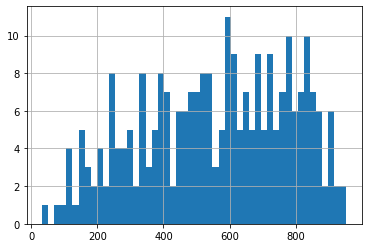

In [72]:
df_data["score"].hist(bins=50)
plt.show()
plt.close()

"""df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(1000-x)*100)
df_data["score"].hist(bins=50)
plt.show()
plt.close()""";

In [73]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [74]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [75]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [76]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(260, 25)
(260, 25)


(260, 2) (260,)


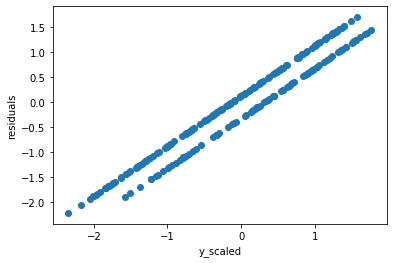

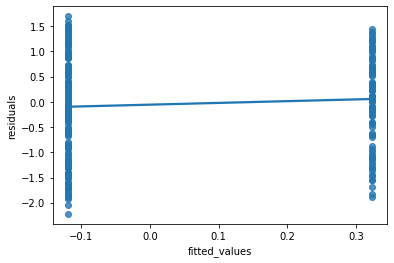

Mean of residuals -0.0371069394751941
RMSE: 0.971993


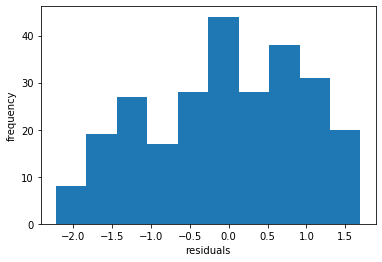

----
Het-Breuschpagan for homogenity:
 (3.26906717743225, 0.0705977561108778, 3.285226764475737, 0.07106827490360308)
Het white for homogenity:
 (3.26906717743225, 0.0705977561108778, 3.285226764475737, 0.07106827490360308)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.054
Model:                            WLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     14.76
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           0.000154
Time:                        14:12:44   Log-Likelihood:                -364.04
No. Observations:                 260   AIC:                             732.1
Df Residuals:                     258   BIC:                             739.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1198      0.082     -1.468      0.143      -0.281       0.041
female         0.4435      0.115      3.842      0.000       0.216       0.671
==============================================================================
Omnibus:                       22.755   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.752
Skew:                          -0.173   Prob(JB):                       0.0126
Kurtosis:                       2.171   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [78]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 99.396041



In [79]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [80]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(260, 21) (260,)


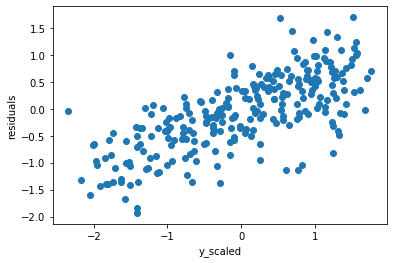

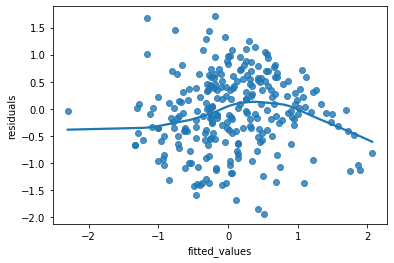

Mean of residuals -0.062857676493624
RMSE: 0.698204


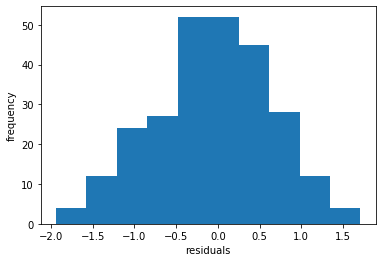

----
Het-Breuschpagan for homogenity:
 (23.585644224155523, 0.2609605833057375, 1.192179923058024, 0.26165221999410854)
Het white for homogenity:
 (157.83370681271074, 0.7894025864560426, 0.7679703762945286, 0.926771808946422)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.490
Model:                            WLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     11.46
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           4.34e-25
Time:                        14:12:54   Log-Likelihood:                -283.84
No. Observations:                 260   AIC:                             609.7
Df Residuals:                     239   BIC:                             684.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0779      0.119      0.656      0.512      -0.156       0.312
age_log2               0.3419      0.059      5.783      0.000       0.225       0.458
solvency_log2         -0.4524      0.055     -8.206      0.000      -0.561      -0.344
credit_card_days       0.2346      0.066      3.542      0.000       0.104       0.365
finance_year_log2     -0.1050      0.057     -1.855      0.065      -0.216       0.007
relocation_**2        -0.0756      0.051     -1.487      0.138      -0.176       0.025
mailOrder             -0.0174      0.126     -0.138      0.890      -0.266       0.231
credit_days_**2       -0.0611      0.053     -1.155      0.249      -0.165       0.043
secured_loan_log2      0.1258      0.057      2.220      0.027       0.014       0.237
conditions_log2       -0.0576      0.055     -1.056      0.292      -0.165       0.050
identity_log2          0.0078      0.054      0.144      0.886      -0.099       0.114
east                  -0.0013      0.102     -0.013      0.990      -0.202       0.199
business_relation     -0.0272      0.048     -0.569      0.570      -0.122       0.067
credit_card            0.0627      0.072      0.870      0.385      -0.079       0.205
banking_connection     0.0443      0.055      0.811      0.418      -0.063       0.152
telecom_log2           0.0626      0.047      1.321      0.188      -0.031       0.156
giro_days              0.0121      0.063      0.194      0.847      -0.112       0.136
monthlyIncome         -0.0797      0.055     -1.442      0.151      -0.189       0.029
giro                   0.1260      0.067      1.876      0.062      -0.006       0.258
global_credit_log2     0.0158      0.048      0.327      0.744      -0.080       0.111
unsecured_loan_**3     0.0245      0.066      0.371      0.711      -0.106       0.155
==============================================================================
Omnibus:                        1.710   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.489
Skew:                          -0.049   Prob(JB):                        0.475
Kurtosis:                       3.357   Cond. No.                         7.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [82]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [83]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(260, 22) (260,)


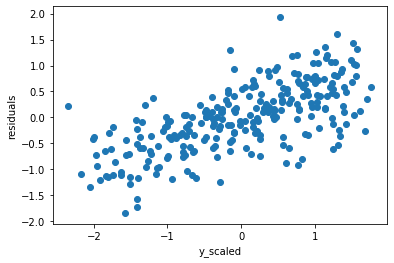

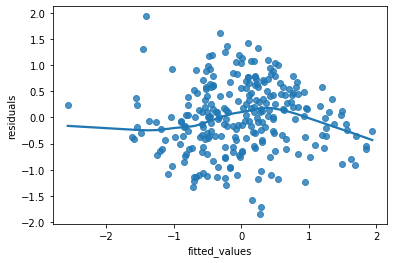

Mean of residuals 0.00522617877581431
RMSE: 0.660191


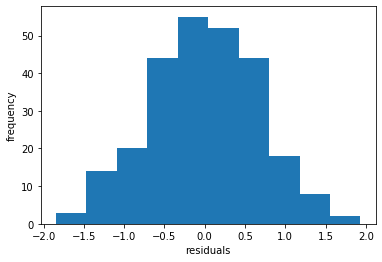

----
Het-Breuschpagan for homogenity:
 (32.06437634932068, 0.057677349354603655, 1.5942934214145503, 0.05142500801078361)
Het white for homogenity:
 (172.0359457993707, 0.7765866439573896, 0.7530171230316343, 0.9333237422720476)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.550
Model:                            WLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     13.88
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.22e-30
Time:                        14:12:58   Log-Likelihood:                -267.33
No. Observations:                 260   AIC:                             578.7
Df Residuals:                     238   BIC:                             657.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1726      0.120     -1.437      0.152      -0.409       0.064
age_log2               0.3339      0.056      6.003      0.000       0.224       0.444
solvency_log2         -0.4678      0.052     -9.010      0.000      -0.570      -0.365
credit_card_days       0.2368      0.062      3.801      0.000       0.114       0.360
female                 0.4796      0.084      5.677      0.000       0.313       0.646
finance_year_log2     -0.1133      0.053     -2.128      0.034      -0.218      -0.008
relocation_**2        -0.0754      0.048     -1.576      0.116      -0.170       0.019
mailOrder             -0.0070      0.118     -0.059      0.953      -0.240       0.226
credit_days_**2       -0.0700      0.050     -1.407      0.161      -0.168       0.028
secured_loan_log2      0.1158      0.053      2.173      0.031       0.011       0.221
conditions_log2       -0.0345      0.051     -0.671      0.503      -0.136       0.067
identity_log2          0.0211      0.051      0.415      0.678      -0.079       0.121
east                   0.0133      0.096      0.139      0.890      -0.175       0.202
business_relation     -0.0277      0.045     -0.616      0.539      -0.116       0.061
credit_card            0.0796      0.068      1.174      0.241      -0.054       0.213
banking_connection     0.0551      0.051      1.072      0.285      -0.046       0.156
telecom_log2           0.0662      0.045      1.485      0.139      -0.022       0.154
giro_days              0.0256      0.059      0.433      0.666      -0.091       0.142
monthlyIncome         -0.0775      0.052     -1.491      0.137      -0.180       0.025
giro                   0.1254      0.063      1.986      0.048       0.001       0.250
global_credit_log2     0.0014      0.046      0.031      0.975      -0.088       0.091
unsecured_loan_**3     0.0479      0.062      0.769      0.443      -0.075       0.171
==============================================================================
Omnibus:                        2.637   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.293
Skew:                          -0.195   Prob(JB):                        0.318
Kurtosis:                       3.244   Cond. No.                         7.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [85]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[4]))

Unit influence of variable: 107.493017



In [86]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Versandhandel, Version 2

In [87]:
variable = "female"

In [88]:
# As an example we use Versandhandel V1
version = 2

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

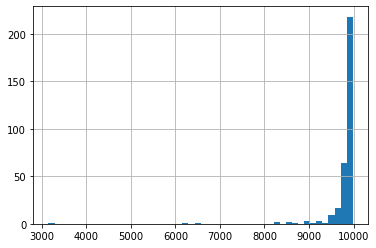

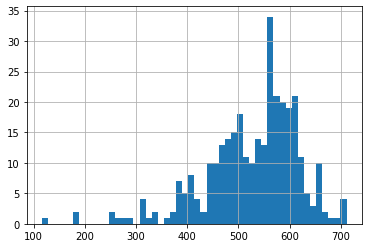

In [89]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)
df_data["score"].hist(bins=50)
plt.show()

In [90]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [91]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [92]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [93]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(324, 25)
(324, 25)


(324, 2) (324,)


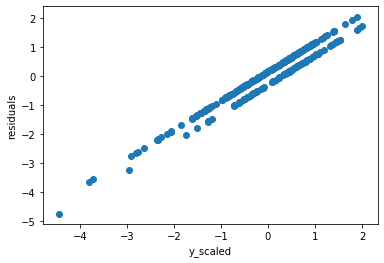

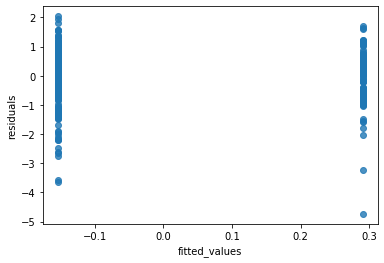

Mean of residuals 0.010832051152300532
RMSE: 0.979966


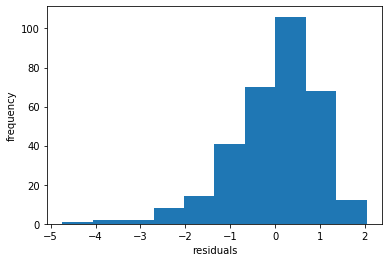

----
Het-Breuschpagan for homogenity:
 (0.2573595690494561, 0.611939996962843, 0.2559742551169973, 0.6132456696871715)
Het white for homogenity:
 (0.2573595690494921, 0.6119399969628182, 0.25597425511705485, 0.6132456696871467)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.050
Model:                            WLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     16.86
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.11e-05
Time:                        14:14:00   Log-Likelihood:                -469.93
No. Observations:                 324   AIC:                             943.9
Df Residuals:                     322   BIC:                             951.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1532      0.076     -2.006      0.046      -0.303      -0.003
female         0.4435      0.108      4.106      0.000       0.231       0.656
==============================================================================
Omnibus:                      109.096   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.546
Skew:                          -1.401   Prob(JB):                     3.58e-96
Kurtosis:                       7.971   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [95]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 40.912328



In [96]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [97]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(324, 21) (324,)


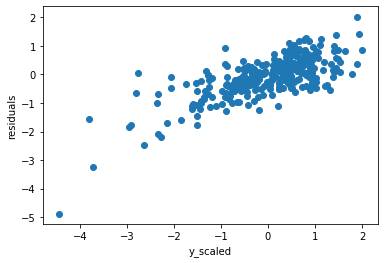

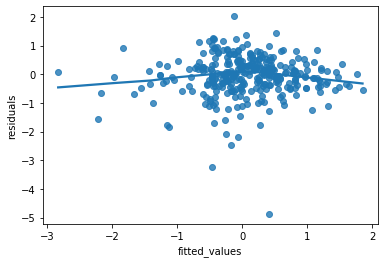

Mean of residuals -0.0644191659857788
RMSE: 0.711832


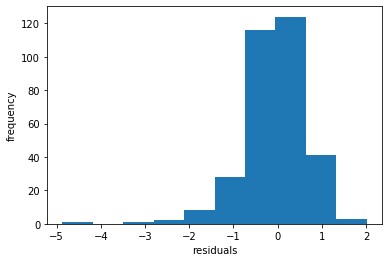

----
Het-Breuschpagan for homogenity:
 (18.354061200249404, 0.5640968627490384, 0.9097586189946314, 0.5749592203954117)
Het white for homogenity:
 (67.46055317226343, 1.0, 0.17038972175305425, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.449
Model:                            WLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     12.35
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           7.18e-29
Time:                        14:14:15   Log-Likelihood:                -381.59
No. Observations:                 324   AIC:                             805.2
Df Residuals:                     303   BIC:                             884.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0201      0.097     -0.208      0.835      -0.210       0.170
age                        0.2080      0.055      3.761      0.000       0.099       0.317
credit_card_days_log2      0.3840      0.058      6.611      0.000       0.270       0.498
credit_card_**2           -0.1505      0.049     -3.057      0.002      -0.247      -0.054
giro                      -0.2875      0.082     -3.520      0.000      -0.448      -0.127
relocation                -0.0703      0.050     -1.417      0.157      -0.168       0.027
solvency                  -0.2986      0.053     -5.632      0.000      -0.403      -0.194
giro_days_log2             0.2878      0.076      3.787      0.000       0.138       0.437
telecom_**2               -0.1029      0.049     -2.103      0.036      -0.199      -0.007
secured_loan_log2          0.1148      0.053      2.174      0.031       0.011       0.219
unsecured_loan_log2       -0.0492      0.050     -0.992      0.322      -0.147       0.048
finance_year_**2          -0.0384      0.049     -0.782      0.435      -0.135       0.058
conditions_log2           -0.0781      0.059     -1.316      0.189      -0.195       0.039
credit_days_**3            0.0398      0.049      0.819      0.413      -0.056       0.136
banking_connection_**3    -0.0604      0.046     -1.303      0.194      -0.152       0.031
east                       0.0980      0.097      1.010      0.313      -0.093       0.289
identity_**3               0.0021      0.057      0.036      0.971      -0.111       0.115
business_relation         -0.0833      0.045     -1.857      0.064      -0.172       0.005
monthlyIncome              0.0926      0.053      1.739      0.083      -0.012       0.197
global_credit             -0.0696      0.052     -1.329      0.185      -0.173       0.033
mailOrder                  0.0726      0.106      0.687      0.493      -0.135       0.281
==============================================================================
Omnibus:                      181.155   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3036.835
Skew:                          -1.911   Prob(JB):                         0.00
Kurtosis:                      17.503   Cond. No.                         5.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [99]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [100]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(324, 22) (324,)


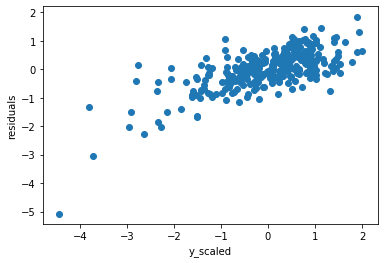

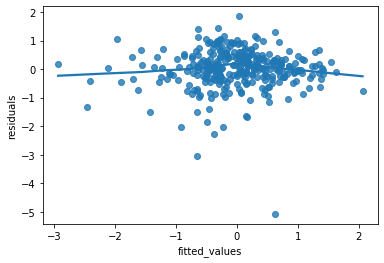

Mean of residuals 0.010807052499515829
RMSE: 0.682778


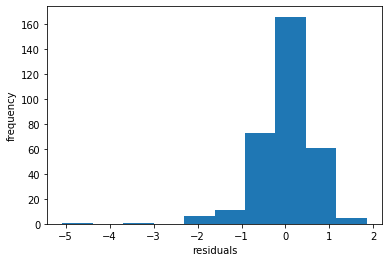

----
Het-Breuschpagan for homogenity:
 (18.279828589757948, 0.631233600010236, 0.8598756937386509, 0.6436970751537481)
Het white for homogenity:
 (101.82189784688936, 0.9999999999775203, 0.24660341336192235, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.494
Model:                            WLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     14.02
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.84e-33
Time:                        14:14:19   Log-Likelihood:                -367.93
No. Observations:                 324   AIC:                             779.9
Df Residuals:                     302   BIC:                             863.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.2141      0.100     -2.138      0.033      -0.411      -0.017
age                        0.1944      0.053      3.656      0.000       0.090       0.299
credit_card_days_log2      0.4000      0.056      7.160      0.000       0.290       0.510
credit_card_**2           -0.1437      0.047     -3.038      0.003      -0.237      -0.051
female                     0.4339      0.084      5.154      0.000       0.268       0.600
giro                      -0.2582      0.079     -3.282      0.001      -0.413      -0.103
relocation                -0.0896      0.048     -1.874      0.062      -0.184       0.004
solvency                  -0.2978      0.051     -5.848      0.000      -0.398      -0.198
giro_days_log2             0.2452      0.073      3.338      0.001       0.101       0.390
telecom_**2               -0.0963      0.047     -2.049      0.041      -0.189      -0.004
secured_loan_log2          0.1228      0.051      2.421      0.016       0.023       0.223
unsecured_loan_log2       -0.0449      0.048     -0.943      0.347      -0.139       0.049
finance_year_**2          -0.0606      0.047     -1.278      0.202      -0.154       0.033
conditions_log2           -0.0602      0.057     -1.054      0.293      -0.173       0.052
credit_days_**3            0.0205      0.047      0.438      0.662      -0.072       0.113
banking_connection_**3    -0.0288      0.045     -0.640      0.523      -0.117       0.060
east                       0.1045      0.093      1.122      0.263      -0.079       0.288
identity_**3               0.0137      0.055      0.248      0.804      -0.095       0.122
business_relation         -0.0998      0.043     -2.308      0.022      -0.185      -0.015
monthlyIncome              0.0918      0.051      1.796      0.073      -0.009       0.192
global_credit             -0.0458      0.050     -0.906      0.365      -0.145       0.054
mailOrder                  0.0445      0.102      0.438      0.662      -0.156       0.245
==============================================================================
Omnibus:                      235.729   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5909.403
Skew:                          -2.633   Prob(JB):                         0.00
Kurtosis:                      23.249   Cond. No.                         6.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [102]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[4]))

Unit influence of variable: 40.025733



In [103]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Versandhandel, Version 3

In [104]:
variable = "female"

In [105]:
version = 3

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

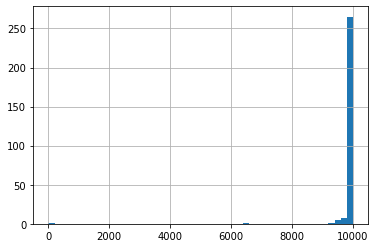

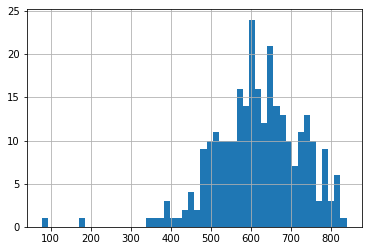

In [106]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)

df_data["score"].hist(bins=50)
plt.show()

In [107]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [108]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [109]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [110]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(281, 25)
(281, 25)


(281, 2) (281,)


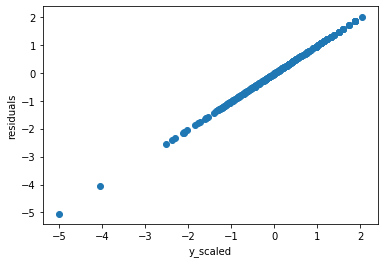

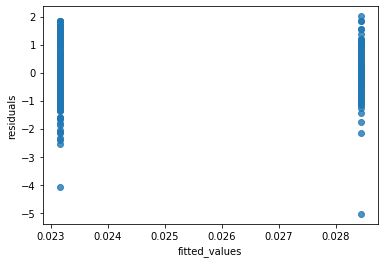

Mean of residuals -0.024862837801130373
RMSE: 1.000263


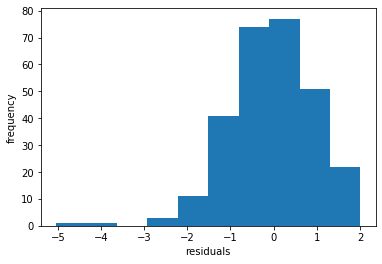

----
Het-Breuschpagan for homogenity:
 (0.11621691453809913, 0.7331743326292581, 0.11543749090799664, 0.7342922022743898)
Het white for homogenity:
 (0.11621691453809913, 0.7331743326292581, 0.11543749090799664, 0.7342922022743898)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.001992
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.964
Time:                        14:14:33   Log-Likelihood:                -414.27
No. Observations:                 281   AIC:                             832.5
Df Residuals:                     279   BIC:                             839.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0231      0.084      0.276      0.783      -0.142       0.188
female         0.0053      0.119      0.045      0.964      -0.228       0.239
==============================================================================
Omnibus:                       70.801   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.186
Skew:                          -0.921   Prob(JB):                     4.07e-76
Kurtosis:                       8.124   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [112]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 0.571258



In [113]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [114]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(281, 21) (281,)


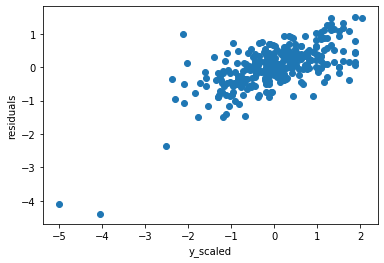

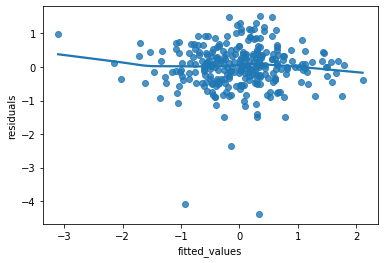

Mean of residuals 0.0026823570537936525
RMSE: 0.684180


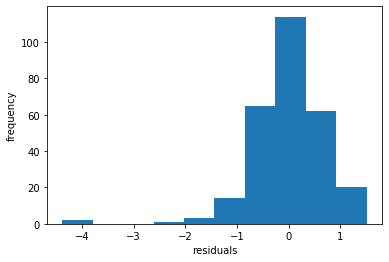

----
Het-Breuschpagan for homogenity:
 (17.99559444992974, 0.5876984723404097, 0.8895011753122479, 0.6008368517672033)
Het white for homogenity:
 (133.0159862754785, 0.9974973087690931, 0.4839981752569849, 0.9999874425976644)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.536
Model:                            WLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     15.01
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           7.14e-33
Time:                        14:14:45   Log-Likelihood:                -306.40
No. Observations:                 281   AIC:                             654.8
Df Residuals:                     260   BIC:                             731.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1310      0.109     -1.197      0.232      -0.347       0.085
age_log2                   0.2636      0.058      4.521      0.000       0.149       0.378
credit_card_days_log2      0.5333      0.079      6.764      0.000       0.378       0.689
credit_card               -0.3894      0.081     -4.817      0.000      -0.549      -0.230
solvency                  -0.1812      0.050     -3.598      0.000      -0.280      -0.082
secured_loan_log2          0.2001      0.046      4.312      0.000       0.109       0.291
telecom                   -0.2761      0.050     -5.559      0.000      -0.374      -0.178
giro_days                  0.1119      0.053      2.104      0.036       0.007       0.217
relocation                -0.0531      0.049     -1.079      0.281      -0.150       0.044
finance_year_log2         -0.1121      0.051     -2.214      0.028      -0.212      -0.012
global_credit_log2        -0.0889      0.052     -1.696      0.091      -0.192       0.014
giro_**2                   0.0113      0.055      0.207      0.836      -0.097       0.119
unsecured_loan            -0.0134      0.055     -0.243      0.808      -0.122       0.095
business_relation_log2    -0.1529      0.046     -3.339      0.001      -0.243      -0.063
identity_**2               0.0126      0.039      0.326      0.745      -0.063       0.089
credit_days_**3            0.0320      0.043      0.738      0.461      -0.053       0.118
monthlyIncome              0.1336      0.055      2.433      0.016       0.025       0.242
conditions_log2           -0.0094      0.052     -0.181      0.856      -0.111       0.092
banking_connection        -0.0097      0.042     -0.233      0.816      -0.091       0.072
east                      -0.0366      0.100     -0.368      0.713      -0.233       0.159
mailOrder                  0.1649      0.117      1.412      0.159      -0.065       0.395
==============================================================================
Omnibus:                      150.331   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1874.827
Skew:                          -1.850   Prob(JB):                         0.00
Kurtosis:                      15.101   Cond. No.                         7.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [116]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [117]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(281, 22) (281,)


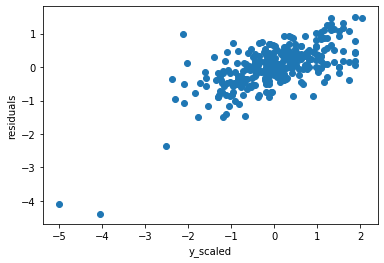

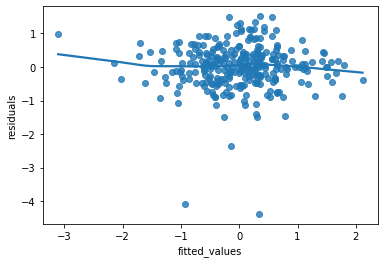

Mean of residuals 0.0021871733020702258
RMSE: 0.684169


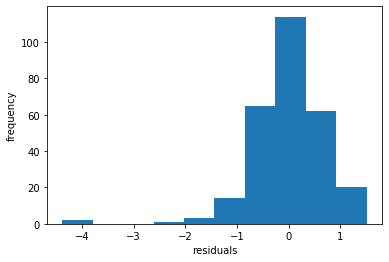

----
Het-Breuschpagan for homogenity:
 (17.96717202619703, 0.6510807215873082, 0.8424618454031901, 0.6658060320130872)
Het white for homogenity:
 (138.35277470340677, 0.9993688480593034, 0.4156691178407108, 0.9999997031412802)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.536
Model:                            WLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     14.24
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.81e-32
Time:                        14:14:49   Log-Likelihood:                -306.40
No. Observations:                 281   AIC:                             656.8
Df Residuals:                     259   BIC:                             736.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1296      0.118     -1.096      0.274      -0.362       0.103
age_log2                   0.2637      0.058      4.510      0.000       0.149       0.379
credit_card_days_log2      0.5334      0.079      6.751      0.000       0.378       0.689
credit_card               -0.3894      0.081     -4.808      0.000      -0.549      -0.230
solvency                  -0.1813      0.051     -3.589      0.000      -0.281      -0.082
secured_loan_log2          0.2000      0.047      4.286      0.000       0.108       0.292
telecom                   -0.2762      0.050     -5.544      0.000      -0.374      -0.178
giro_days                  0.1119      0.053      2.100      0.037       0.007       0.217
relocation                -0.0530      0.049     -1.073      0.284      -0.150       0.044
finance_year_log2         -0.1119      0.051     -2.199      0.029      -0.212      -0.012
global_credit_log2        -0.0890      0.053     -1.692      0.092      -0.193       0.015
giro_**2                   0.0113      0.055      0.206      0.837      -0.097       0.119
unsecured_loan            -0.0134      0.055     -0.243      0.808      -0.122       0.095
business_relation_log2    -0.1528      0.046     -3.325      0.001      -0.243      -0.062
identity_**2               0.0125      0.039      0.323      0.747      -0.064       0.089
credit_days_**3            0.0322      0.044      0.737      0.462      -0.054       0.118
monthlyIncome              0.1337      0.055      2.428      0.016       0.025       0.242
conditions_log2           -0.0094      0.052     -0.181      0.856      -0.111       0.092
banking_connection        -0.0097      0.042     -0.233      0.816      -0.092       0.072
east                      -0.0368      0.100     -0.368      0.713      -0.234       0.160
female                    -0.0028      0.085     -0.033      0.974      -0.170       0.165
mailOrder                  0.1649      0.117      1.409      0.160      -0.065       0.395
==============================================================================
Omnibus:                      150.155   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1869.682
Skew:                          -1.848   Prob(JB):                         0.00
Kurtosis:                      15.084   Cond. No.                         7.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [119]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-2]))

Unit influence of variable: -0.305056



In [120]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

## East_west

In [121]:
table2 = pd.read_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_east_west.csv", sep=";")

In [122]:
table2 = prepare_type(table2)

In [123]:
variable = "east"

### Versandhandel - Version 1

In [124]:
domain = "Versandhandel"

In [125]:
# As an example we use Versandhandel V1
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

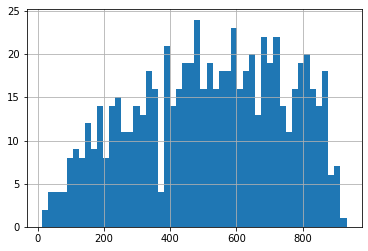

In [126]:
df_data["score"].hist(bins=50)
plt.show()
plt.close()

"""df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(1000-x)*100)
df_data["score"].hist(bins=50)
plt.show()
plt.close()""";

In [127]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [128]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [129]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [130]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(693, 25)
(693, 25)


(693, 2) (693,)


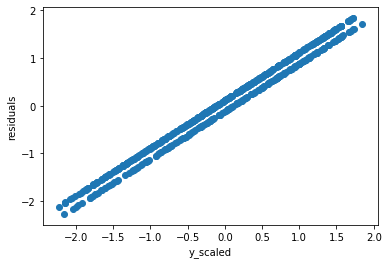

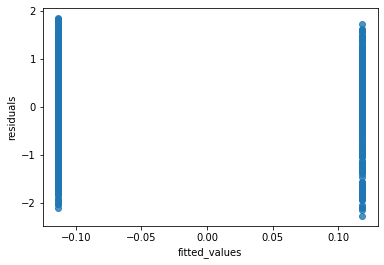

Mean of residuals 0.03674340417287051
RMSE: 0.997550


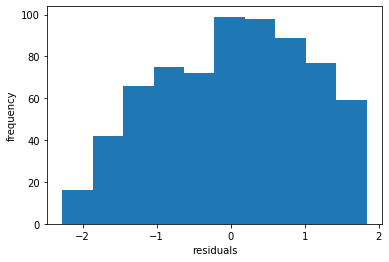

----
Het-Breuschpagan for homogenity:
 (0.02146560419749377, 0.883517653771863, 0.02140431739839236, 0.8837255432417128)
Het white for homogenity:
 (0.021465604197647647, 0.8835176537714484, 0.021404317398501252, 0.883725543241299)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     9.303
Date:                Sat, 24 Aug 2019   Prob (F-statistic):            0.00237
Time:                        14:15:16   Log-Likelihood:                -1024.1
No. Observations:                 693   AIC:                             2052.
Df Residuals:                     691   BIC:                             2061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1133      0.054     -2.110      0.035      -0.219      -0.008
east           0.2316      0.076      3.050      0.002       0.083       0.381
==============================================================================
Omnibus:                       20.983   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.355
Skew:                          -0.333   Prob(JB):                     0.000103
Kurtosis:                       2.563   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [132]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 52.283733



In [133]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [134]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(693, 21) (693,)


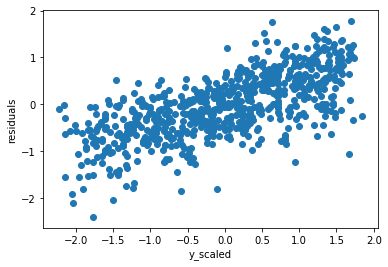

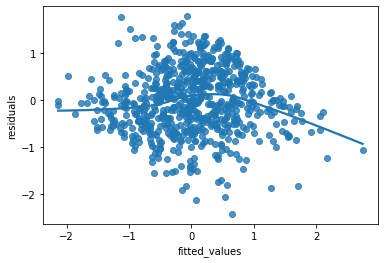

Mean of residuals -0.019929385162089308
RMSE: 0.686853


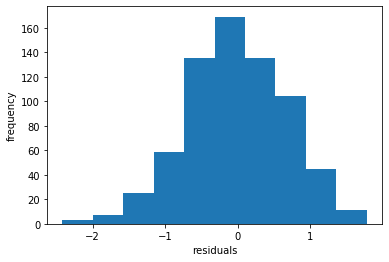

----
Het-Breuschpagan for homogenity:
 (23.107150646944827, 0.28356389621123984, 1.1589917141034556, 0.2842734275506817)
Het white for homogenity:
 (200.4979045996858, 0.9052594233606578, 0.8284854566236866, 0.9465581035235148)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.530
Model:                            WLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     37.95
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.98e-96
Time:                        14:15:40   Log-Likelihood:                -766.83
No. Observations:                 693   AIC:                             1576.
Df Residuals:                     672   BIC:                             1671.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0738      0.070      1.054      0.292      -0.064       0.211
age_log2               0.3168      0.035      8.959      0.000       0.247       0.386
solvency_log2         -0.3615      0.032    -11.181      0.000      -0.425      -0.298
credit_card_days       0.2388      0.041      5.807      0.000       0.158       0.320
female                 0.3181      0.092      3.460      0.001       0.138       0.499
finance_year_log2     -0.1566      0.037     -4.260      0.000      -0.229      -0.084
relocation_**2        -0.0633      0.028     -2.226      0.026      -0.119      -0.007
mailOrder             -0.0948      0.076     -1.245      0.214      -0.244       0.055
credit_days_**2       -0.1270      0.036     -3.517      0.000      -0.198      -0.056
secured_loan_log2      0.0613      0.035      1.755      0.080      -0.007       0.130
conditions_log2       -0.1094      0.030     -3.616      0.000      -0.169      -0.050
identity_log2          0.0700      0.031      2.270      0.024       0.009       0.131
business_relation     -0.0064      0.029     -0.223      0.823      -0.063       0.050
credit_card            0.1457      0.042      3.472      0.001       0.063       0.228
banking_connection    -0.0624      0.027     -2.336      0.020      -0.115      -0.010
telecom_log2          -0.0106      0.029     -0.367      0.714      -0.068       0.046
giro_days              0.0425      0.040      1.066      0.287      -0.036       0.121
monthlyIncome          0.0781      0.033      2.354      0.019       0.013       0.143
giro                   0.0410      0.044      0.923      0.356      -0.046       0.128
global_credit_log2     0.0626      0.032      1.935      0.053      -0.001       0.126
unsecured_loan_**3     0.0127      0.027      0.470      0.639      -0.040       0.066
==============================================================================
Omnibus:                        4.367   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.809
Skew:                          -0.095   Prob(JB):                       0.0903
Kurtosis:                       3.361   Cond. No.                         7.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [136]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [137]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(693, 22) (693,)


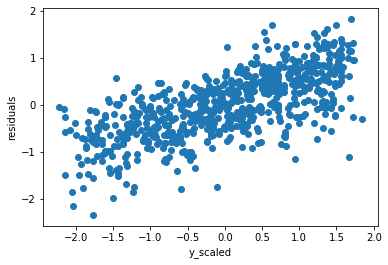

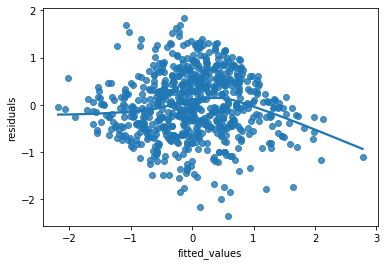

Mean of residuals -0.0008945766754903867
RMSE: 0.684347


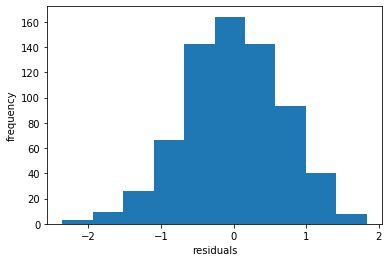

----
Het-Breuschpagan for homogenity:
 (23.30009184951033, 0.32818918431120875, 1.1116821160347594, 0.32967759291126186)
Het white for homogenity:
 (213.570466333974, 0.9494588102596637, 0.7925392713532684, 0.979295295940742)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.533
Model:                            WLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     36.53
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.17e-96
Time:                        14:15:44   Log-Likelihood:                -764.56
No. Observations:                 693   AIC:                             1573.
Df Residuals:                     671   BIC:                             1673.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0161      0.075      0.215      0.830      -0.131       0.163
age_log2               0.3151      0.035      8.930      0.000       0.246       0.384
solvency_log2         -0.3578      0.032    -11.081      0.000      -0.421      -0.294
credit_card_days       0.2362      0.041      5.756      0.000       0.156       0.317
female                 0.3053      0.092      3.322      0.001       0.125       0.486
finance_year_log2     -0.1577      0.037     -4.302      0.000      -0.230      -0.086
relocation_**2        -0.0636      0.028     -2.243      0.025      -0.119      -0.008
mailOrder             -0.0919      0.076     -1.210      0.227      -0.241       0.057
credit_days_**2       -0.1230      0.036     -3.411      0.001      -0.194      -0.052
secured_loan_log2      0.0607      0.035      1.742      0.082      -0.008       0.129
conditions_log2       -0.1108      0.030     -3.672      0.000      -0.170      -0.052
identity_log2          0.0687      0.031      2.234      0.026       0.008       0.129
east                   0.1128      0.054      2.104      0.036       0.008       0.218
business_relation     -0.0054      0.029     -0.188      0.851      -0.061       0.051
credit_card            0.1448      0.042      3.460      0.001       0.063       0.227
banking_connection    -0.0624      0.027     -2.342      0.019      -0.115      -0.010
telecom_log2          -0.0141      0.029     -0.488      0.626      -0.071       0.043
giro_days              0.0449      0.040      1.128      0.260      -0.033       0.123
monthlyIncome          0.0761      0.033      2.300      0.022       0.011       0.141
giro                   0.0438      0.044      0.989      0.323      -0.043       0.131
global_credit_log2     0.0608      0.032      1.883      0.060      -0.003       0.124
unsecured_loan_**3     0.0143      0.027      0.533      0.594      -0.038       0.067
==============================================================================
Omnibus:                        6.912   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.545
Skew:                          -0.165   Prob(JB):                       0.0230
Kurtosis:                       3.390   Cond. No.                         7.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [139]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[12]))

Unit influence of variable: 25.472883



In [140]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Versandhandel, Version 2

In [141]:
variable = "east"

In [142]:
# As an example we use Versandhandel V1
version = 2

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

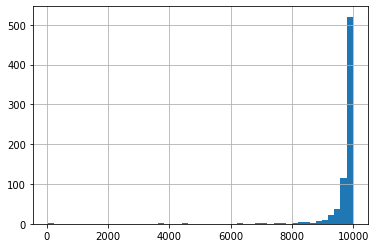

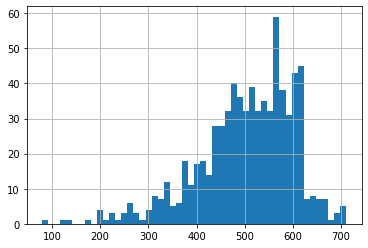

In [143]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)
df_data["score"].hist(bins=50)
plt.show()

In [144]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [145]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [146]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [147]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(734, 25)
(734, 25)


(734, 2) (734,)


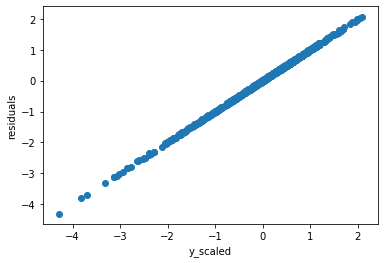

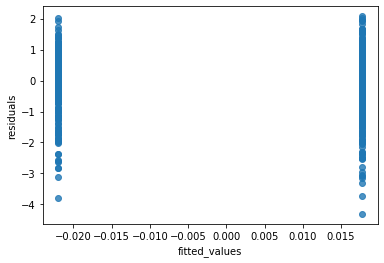

Mean of residuals -0.004422325476802263
RMSE: 0.999892


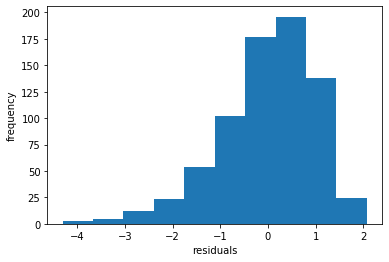

----
Het-Breuschpagan for homogenity:
 (0.21527810281409487, 0.6426615633667596, 0.21475450027425252, 0.64320388089308)
Het white for homogenity:
 (0.21527810281409487, 0.6426615633667596, 0.21475450027425252, 0.64320388089308)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2880
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.592
Time:                        14:16:11   Log-Likelihood:                -1087.8
No. Observations:                 734   AIC:                             2180.
Df Residuals:                     732   BIC:                             2189.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.052      0.340      0.734      -0.085       0.121
east          -0.0398      0.074     -0.537      0.592      -0.185       0.106
==============================================================================
Omnibus:                      106.697   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.712
Skew:                          -0.922   Prob(JB):                     2.57e-39
Kurtosis:                       4.553   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [149]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: -3.933662



In [150]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [151]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(734, 21) (734,)


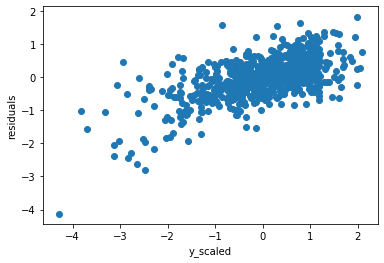

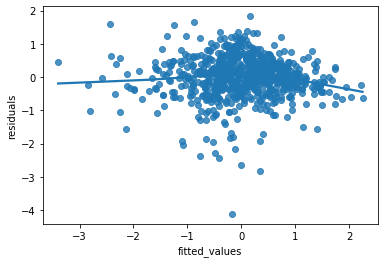

Mean of residuals 0.0054782683936298905
RMSE: 0.636184


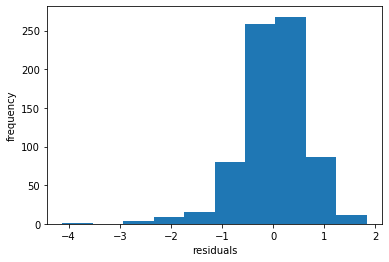

----
Het-Breuschpagan for homogenity:
 (50.99133141949458, 0.00015950044424609144, 2.661519609821344, 0.00011464355199277749)
Het white for homogenity:
 (134.32562337608738, 0.9999998375161744, 0.4993074338429909, 0.9999999971612485)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.619
Model:                            WLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     57.89
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          1.74e-134
Time:                        14:16:39   Log-Likelihood:                -733.89
No. Observations:                 734   AIC:                             1510.
Df Residuals:                     713   BIC:                             1606.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0042      0.056     -0.076      0.940      -0.114       0.106
age                        0.3210      0.029     11.042      0.000       0.264       0.378
credit_card_days_log2      0.3361      0.032     10.547      0.000       0.274       0.399
credit_card_**2           -0.1207      0.031     -3.943      0.000      -0.181      -0.061
female                     0.3658      0.077      4.729      0.000       0.214       0.518
giro                      -0.2477      0.041     -5.971      0.000      -0.329      -0.166
relocation                -0.0943      0.025     -3.724      0.000      -0.144      -0.045
solvency                  -0.3913      0.028    -14.128      0.000      -0.446      -0.337
giro_days_log2             0.2419      0.038      6.311      0.000       0.167       0.317
telecom_**2               -0.0808      0.022     -3.632      0.000      -0.124      -0.037
secured_loan_log2          0.1108      0.028      3.920      0.000       0.055       0.166
unsecured_loan_log2       -0.0445      0.027     -1.634      0.103      -0.098       0.009
finance_year_**2          -0.0093      0.031     -0.301      0.763      -0.070       0.051
conditions_log2           -0.1531      0.027     -5.624      0.000      -0.207      -0.100
credit_days_**3           -0.0493      0.030     -1.645      0.100      -0.108       0.010
banking_connection_**3    -0.0023      0.025     -0.092      0.927      -0.050       0.046
identity_**3               0.0046      0.027      0.175      0.861      -0.048       0.057
business_relation         -0.0585      0.025     -2.327      0.020      -0.108      -0.009
monthlyIncome              0.0289      0.027      1.053      0.293      -0.025       0.083
global_credit             -0.0491      0.027     -1.835      0.067      -0.102       0.003
mailOrder                 -0.0448      0.062     -0.725      0.469      -0.166       0.076
==============================================================================
Omnibus:                      143.071   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              505.020
Skew:                          -0.893   Prob(JB):                    2.17e-110
Kurtosis:                       6.650   Cond. No.                         6.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [153]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [154]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(734, 22) (734,)


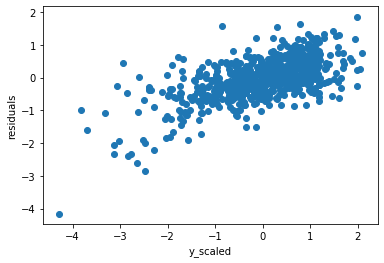

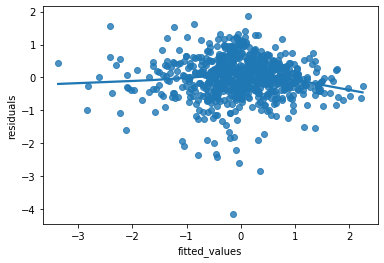

Mean of residuals -0.002954064016209649
RMSE: 0.635733


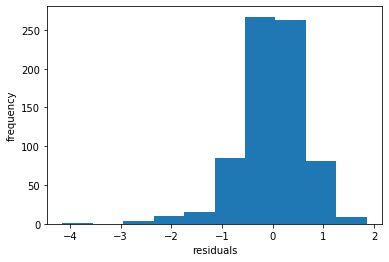

----
Het-Breuschpagan for homogenity:
 (49.927251130545514, 0.00037339899245150443, 2.4745490372741634, 0.0002801944901086152)
Het white for homogenity:
 (142.46875974234993, 0.999999990456327, 0.4710120474851064, 0.9999999999531739)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.620
Model:                            WLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     55.21
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          7.35e-134
Time:                        14:16:43   Log-Likelihood:                -733.26
No. Observations:                 734   AIC:                             1511.
Df Residuals:                     712   BIC:                             1612.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0224      0.061      0.368      0.713      -0.097       0.142
age                        0.3213      0.029     11.054      0.000       0.264       0.378
credit_card_days_log2      0.3369      0.032     10.569      0.000       0.274       0.399
credit_card_**2           -0.1214      0.031     -3.965      0.000      -0.182      -0.061
female                     0.3684      0.077      4.761      0.000       0.216       0.520
giro                      -0.2466      0.041     -5.942      0.000      -0.328      -0.165
relocation                -0.0943      0.025     -3.721      0.000      -0.144      -0.045
solvency                  -0.3920      0.028    -14.150      0.000      -0.446      -0.338
giro_days_log2             0.2403      0.038      6.266      0.000       0.165       0.316
telecom_**2               -0.0798      0.022     -3.585      0.000      -0.123      -0.036
secured_loan_log2          0.1111      0.028      3.928      0.000       0.056       0.167
unsecured_loan_log2       -0.0445      0.027     -1.633      0.103      -0.098       0.009
finance_year_**2          -0.0101      0.031     -0.329      0.743      -0.070       0.050
conditions_log2           -0.1509      0.027     -5.532      0.000      -0.205      -0.097
credit_days_**3           -0.0496      0.030     -1.657      0.098      -0.108       0.009
banking_connection_**3    -0.0020      0.025     -0.082      0.935      -0.050       0.046
east                      -0.0517      0.047     -1.107      0.269      -0.143       0.040
identity_**3               0.0052      0.027      0.194      0.846      -0.047       0.057
business_relation         -0.0589      0.025     -2.343      0.019      -0.108      -0.010
monthlyIncome              0.0295      0.027      1.075      0.283      -0.024       0.083
global_credit             -0.0487      0.027     -1.820      0.069      -0.101       0.004
mailOrder                 -0.0461      0.062     -0.747      0.456      -0.167       0.075
==============================================================================
Omnibus:                      137.213   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.744
Skew:                          -0.857   Prob(JB):                    1.49e-105
Kurtosis:                       6.585   Cond. No.                         6.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [156]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-6]))

Unit influence of variable: -5.108221



In [157]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Versandhandel, Version 3

In [158]:
variable = "east"

In [159]:
version = 3

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

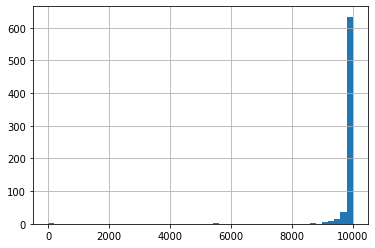

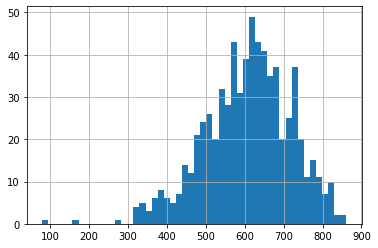

In [160]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)

df_data["score"].hist(bins=50)
plt.show()

In [161]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [162]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [163]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [164]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(702, 25)
(702, 25)


(702, 2) (702,)


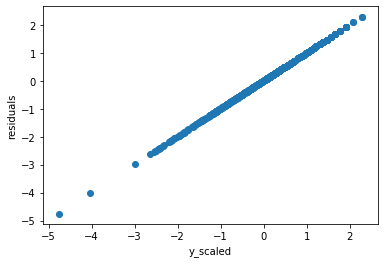

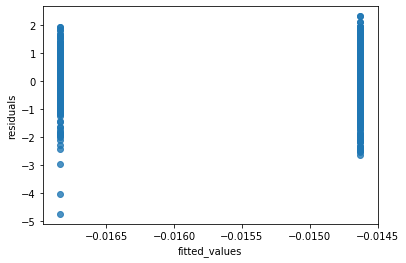

Mean of residuals 0.015328994696870912
RMSE: 1.000106


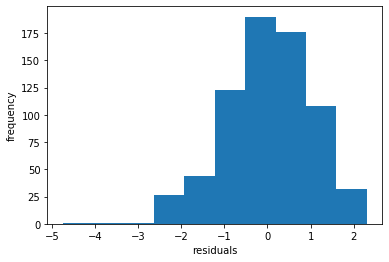

----
Het-Breuschpagan for homogenity:
 (0.18987979063447002, 0.6630166855473716, 0.18939004955425204, 0.6635589026106703)
Het white for homogenity:
 (0.18987979063447002, 0.6630166855473716, 0.18939004955425204, 0.6635589026106703)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 0.0008541
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.977
Time:                        14:17:05   Log-Likelihood:                -1040.4
No. Observations:                 702   AIC:                             2085.
Df Residuals:                     700   BIC:                             2094.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0146      0.054     -0.273      0.785      -0.120       0.091
east          -0.0022      0.076     -0.029      0.977      -0.151       0.146
==============================================================================
Omnibus:                       95.592   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.282
Skew:                          -0.713   Prob(JB):                     1.49e-53
Kurtosis:                       5.506   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [166]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: -0.245371



In [167]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [168]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(702, 21) (702,)


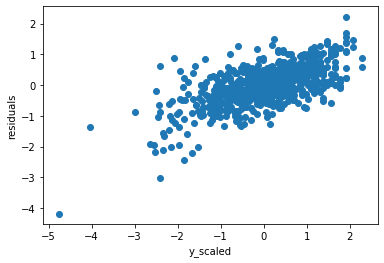

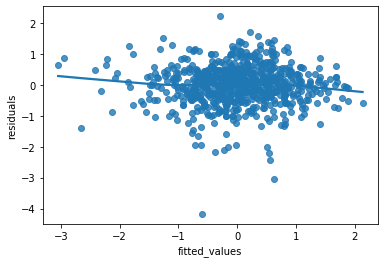

Mean of residuals 0.005432340004225991
RMSE: 0.655497


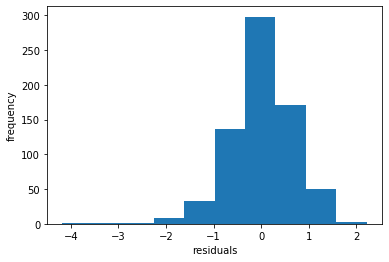

----
Het-Breuschpagan for homogenity:
 (41.95814282842649, 0.00280052447389403, 2.164521458427062, 0.002364331436633597)
Het white for homogenity:
 (277.9354622200208, 0.013298689982105236, 1.3596849800423172, 0.0029787300570183624)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.576
Model:                            WLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     46.32
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          1.36e-112
Time:                        14:17:16   Log-Likelihood:                -738.92
No. Observations:                 702   AIC:                             1520.
Df Residuals:                     681   BIC:                             1615.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0069      0.061      0.114      0.910      -0.113       0.127
age_log2                   0.3763      0.033     11.434      0.000       0.312       0.441
credit_card_days_log2      0.4541      0.045     10.156      0.000       0.366       0.542
credit_card               -0.2574      0.045     -5.734      0.000      -0.346      -0.169
solvency                  -0.2779      0.031     -8.973      0.000      -0.339      -0.217
secured_loan_log2          0.1717      0.031      5.492      0.000       0.110       0.233
telecom                   -0.2148      0.026     -8.309      0.000      -0.266      -0.164
giro_days                  0.1184      0.032      3.658      0.000       0.055       0.182
relocation                -0.0603      0.028     -2.162      0.031      -0.115      -0.006
finance_year_log2         -0.0644      0.033     -1.948      0.052      -0.129       0.000
global_credit_log2        -0.0677      0.028     -2.426      0.016      -0.123      -0.013
giro_**2                  -0.0468      0.035     -1.342      0.180      -0.115       0.022
unsecured_loan            -0.0311      0.028     -1.128      0.260      -0.085       0.023
business_relation_log2    -0.0971      0.027     -3.619      0.000      -0.150      -0.044
identity_**2               0.0053      0.029      0.181      0.856      -0.052       0.063
credit_days_**3           -0.0567      0.034     -1.676      0.094      -0.123       0.010
monthlyIncome              0.0529      0.031      1.703      0.089      -0.008       0.114
conditions_log2           -0.0566      0.029     -1.962      0.050      -0.113    5.39e-05
banking_connection        -0.0069      0.027     -0.258      0.796      -0.059       0.045
female                    -0.0092      0.087     -0.105      0.916      -0.180       0.162
mailOrder                 -0.0137      0.068     -0.202      0.840      -0.147       0.120
==============================================================================
Omnibus:                      192.631   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1520.304
Skew:                          -0.999   Prob(JB):                         0.00
Kurtosis:                       9.927   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [170]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [171]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(702, 22) (702,)


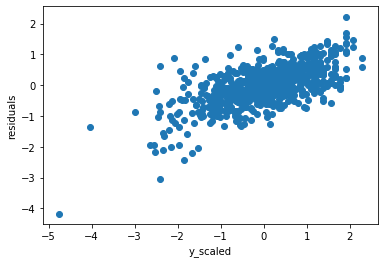

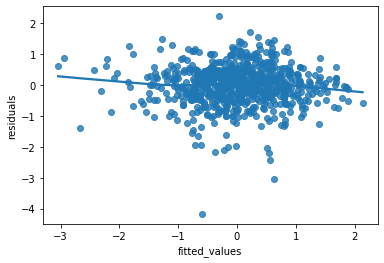

Mean of residuals 0.003831848180979833
RMSE: 0.655475


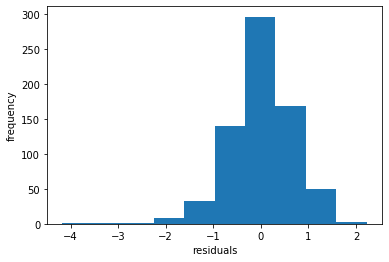

----
Het-Breuschpagan for homogenity:
 (41.92729963129176, 0.004297160403475161, 2.056812669368719, 0.0036846202157986116)
Het white for homogenity:
 (298.6705909215919, 0.016904203296331376, 1.344224042526502, 0.0035411028162238597)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.576
Model:                            WLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     44.06
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          9.26e-112
Time:                        14:17:19   Log-Likelihood:                -738.91
No. Observations:                 702   AIC:                             1522.
Df Residuals:                     680   BIC:                             1622.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0111      0.066      0.170      0.865      -0.118       0.140
age_log2                   0.3764      0.033     11.427      0.000       0.312       0.441
credit_card_days_log2      0.4542      0.045     10.150      0.000       0.366       0.542
credit_card               -0.2573      0.045     -5.728      0.000      -0.346      -0.169
solvency                  -0.2781      0.031     -8.967      0.000      -0.339      -0.217
secured_loan_log2          0.1717      0.031      5.488      0.000       0.110       0.233
telecom                   -0.2148      0.026     -8.304      0.000      -0.266      -0.164
giro_days                  0.1182      0.032      3.648      0.000       0.055       0.182
relocation                -0.0601      0.028     -2.152      0.032      -0.115      -0.005
finance_year_log2         -0.0643      0.033     -1.944      0.052      -0.129       0.001
global_credit_log2        -0.0677      0.028     -2.424      0.016      -0.123      -0.013
giro_**2                  -0.0469      0.035     -1.344      0.179      -0.115       0.022
unsecured_loan            -0.0311      0.028     -1.127      0.260      -0.085       0.023
business_relation_log2    -0.0970      0.027     -3.616      0.000      -0.150      -0.044
identity_**2               0.0052      0.029      0.177      0.859      -0.052       0.063
credit_days_**3           -0.0567      0.034     -1.674      0.095      -0.123       0.010
monthlyIncome              0.0529      0.031      1.703      0.089      -0.008       0.114
conditions_log2           -0.0564      0.029     -1.954      0.051      -0.113       0.000
banking_connection        -0.0069      0.027     -0.259      0.796      -0.059       0.046
east                      -0.0088      0.050     -0.175      0.861      -0.107       0.090
female                    -0.0093      0.087     -0.106      0.915      -0.180       0.162
mailOrder                 -0.0135      0.068     -0.198      0.843      -0.147       0.120
==============================================================================
Omnibus:                      191.266   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1508.169
Skew:                          -0.991   Prob(JB):                         0.00
Kurtosis:                       9.902   Cond. No.                         7.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [172]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [173]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-3]))

Unit influence of variable: -0.976565



In [174]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)